In [1]:
import numpy as np
import rasterio
import ee
import fiona
import rasterio.mask
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


ee.Initialize()

In [2]:
with rasterio.open("mudanca_romp.tif") as changes:
    mudancas = changes.read()

In [3]:
from matplotlib.pyplot import figure

def aplica_labels(df1, maximo):
    df1.loc[df1["anomalies"]<int(0.2*maximo),'label'] = "Very low"
    df1.loc[(df1["anomalies"]<int(0.4*maximo)) & (df1["anomalies"]>=int(0.2*maximo)),'label'] = "Low"
    df1.loc[(df1["anomalies"]<int(0.6*maximo)) & (df1["anomalies"]>=int(0.4*maximo)),'label'] = "Medium"
    df1.loc[(df1["anomalies"]<int(0.8*maximo)) & (df1["anomalies"]>=int(0.6*maximo)),'label'] = "High"
    df1.loc[df1["anomalies"]>=int(0.8*maximo),'label'] = "Very high"
    df1.reset_index(inplace=True, drop=True)
    df1.loc[df1['label']=="Very high", 'id'] = 5
    df1.loc[df1['label']=="High", 'id'] = 4
    df1.loc[df1['label']=="Medium", 'id'] = 3
    df1.loc[df1['label']=="Low", 'id'] = 2
    df1.loc[df1['label']=="Very low", 'id'] = 1
    return df1

def gera_data(link_shp,link_shp2,link_tiff):
    with fiona.open(link_shp) as shape_afetadas:
        afetadas = [feature["geometry"] for feature in shape_afetadas]

    with rasterio.open(link_tiff) as regress:
        afetadas_regress, out_transform = rasterio.mask.mask(regress, afetadas, crop=True)
        out_meta = regress.meta

    out_meta.update({"driver": "GTiff",
                     "height": afetadas_regress.shape[1],
                     "width": afetadas_regress.shape[2],
                     "transform": out_transform})

    #with rasterio.open("afetadas.tif", "w", **out_meta) as dest:
     #   dest.write(afetadas_regress)

    df1 = pd.DataFrame(columns=['anomalies'],data=list(zip(afetadas_regress.flatten())))
    remove_index = df1[df1['anomalies']<1].index
    df1 = df1.drop(remove_index)
    maximo = df1.max().values
    df1 = aplica_labels(df1, maximo)
    
    with fiona.open(link_shp2) as shape_afetadas2:
        afetadas2 = [feature["geometry"] for feature in shape_afetadas2]
        
    with rasterio.open(link_tiff) as regress:
        afetadas_regress2, out_transform2 = rasterio.mask.mask(regress, afetadas2, crop=True)
        out_meta = regress.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": afetadas_regress2.shape[1],
                     "width": afetadas_regress2.shape[2],
                     "transform": out_transform2})
    df2 = pd.DataFrame(columns=['anomalies'],data=list(zip(afetadas_regress2.flatten())))
    remove_index = df2[df2['anomalies']<1].index
    df2 = df2.drop(remove_index)
    df2 = aplica_labels(df2, maximo)
    resu = pd.concat([df1,df2])
    return resu, df1, df2

def histo_gera(df1, df2, year):
    figure(figsize=(14,10), dpi=300)
    titulo = "NDWI Anomalies for Feijão Dam, Brumadinho-MG " + year
    plt.title(titulo, fontsize=25)
    plt.xlabel('Anomaly count', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    labels1 = df1.sort_values(by=['id'])['label'].unique()
    t1 = []
    t2 = []
    for label in labels1:
        t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])

    labels2 = df2.sort_values(by=['id'])['label'].unique()
    for label in labels2:
        t2.append(df2.sort_values(by=['id'])['label'].value_counts()[label])

    yy = t1/np.sum(t1)
    y2 = t2/np.sum(t2)
    xx = np.arange(len(labels1))
    x2 = np.arange(len(labels2))
    width = 0.35
    ax = plt.subplot(111)
    ax.bar(x2 + width/2, y2, width, color='#07051b', label='Non Changes')
    ax.bar(xx - width/2, yy, width, color='#e25734', label='Changes')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xticks(xx)
    ax.set_xticklabels(labels1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    ax.legend()
    plt.legend(fontsize=20)
    path = "../../Brumadinho/PNG/V3_Sep_22/" + titulo + ".png"
    plt.savefig(path)
    return 'ok' + titulo

In [4]:
def histo_gera2(df1, year):
    figure(figsize=(14,10), dpi=300)
    titulo = "NDWI Anomalies for Feijão Dam, Brumadinho-MG " + year
    plt.title(titulo, fontsize=25)
    plt.xlabel('Anomaly count', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    labels1 = df1.sort_values(by=['id'])['label'].unique()
    t1 = []
    for label in labels1:
        t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])

    yy = t1/np.sum(t1)
    xx = np.arange(len(labels1))
    width = 0.35
    ax = plt.subplot(111)
    ax.bar(xx - width/2, yy, width, color='#e25734', label='Isolation Forest')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xticks(xx)
    ax.set_xticklabels(labels1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    ax.legend()
    plt.legend(fontsize=20)
    path = "../../Brumadinho/PNG/V3_Sep_22/" + titulo + ".png"
    plt.savefig(path)
    return 'ok' + titulo

In [5]:
def histo_gera3(df1, df2, year):
    figure(figsize=(14,10), dpi=300)
    titulo = "NDWI Anomalies for Feijão Dam, Brumadinho-MG " + year
    plt.title(titulo, fontsize=25)
    plt.xlabel('Anomaly count', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    labels1 = df1.sort_values(by=['id'])['label'].unique()
    t1 = []
    t2 = []
    for label in labels1:
        t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])

    labels2 = df2.sort_values(by=['id'])['label'].unique()
    for label in labels2:
        t2.append(df2.sort_values(by=['id'])['label'].value_counts()[label])

    yy = t1/np.sum(t1)
    y2 = t2/np.sum(t2)
    xx = np.arange(len(labels1))
    x2 = np.arange(len(labels2))
    width = 0.35
    ax = plt.subplot(111)
    ax.bar(x2 + width/2, y2, width, color='#07051b', label='Non Changes')
    ax.bar(xx - width/2, yy, width, color='#e25734', label='Changes')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xticks(xx)
    ax.set_xticklabels(labels1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    ax.legend()
    plt.legend(fontsize=20)
    path = "../../Brumadinho/PNG/V3_Sep_22/" + titulo + ".png"
    plt.savefig(path)
    return 'ok' + titulo

# IF - Validation

In [6]:
bru_shp_path = "../../../qgis/Barragens/Brumadinho/v2/rastrolamaBru.shp"
import os
path = "../../Brumadinho/Tiff/V4_Out_22/"
inter_anos = []
dict_if_path = {}
for x in os.listdir(path):
    if x.endswith(".tif"):
        ano = x[19:-4] + "_Estimators"
        inter_anos.append(ano)
        dict_if_path[ano] = path + x
        
dict_if_path

{'100_Estimators': '../../Brumadinho/Tiff/V4_Out_22/Brumadinho_NDWI_IF_100.tif',
 '20_Estimators': '../../Brumadinho/Tiff/V4_Out_22/Brumadinho_NDWI_IF_20.tif',
 '40_Estimators': '../../Brumadinho/Tiff/V4_Out_22/Brumadinho_NDWI_IF_40.tif',
 '60_Estimators': '../../Brumadinho/Tiff/V4_Out_22/Brumadinho_NDWI_IF_60.tif',
 '80_Estimators': '../../Brumadinho/Tiff/V4_Out_22/Brumadinho_NDWI_IF_80.tif'}

In [7]:
dict_ocsvm_path = {}
nuu = [0.001, 0.005, 0.01, 0.05, 0.1]
cont = 0
path = "../../Brumadinho/Tiff/V3_Sep_22/OCSVM/"
for x in os.listdir(path):
    if x.endswith(".tif"):
        ano = str(nuu[cont]) + "_nu"
        inter_anos.append(ano)
        dict_ocsvm_path[ano] = path + x
        cont += 1
        
dict_ocsvm_path

{'0.001_nu': '../../Brumadinho/Tiff/V3_Sep_22/OCSVM/Brumadinho_NDWI_OCSVM_0.001.tif',
 '0.005_nu': '../../Brumadinho/Tiff/V3_Sep_22/OCSVM/Brumadinho_NDWI_OCSVM_0.005.tif',
 '0.01_nu': '../../Brumadinho/Tiff/V3_Sep_22/OCSVM/Brumadinho_NDWI_OCSVM_0.01.tif',
 '0.05_nu': '../../Brumadinho/Tiff/V3_Sep_22/OCSVM/Brumadinho_NDWI_OCSVM_0.05.tif',
 '0.1_nu': '../../Brumadinho/Tiff/V3_Sep_22/OCSVM/Brumadinho_NDWI_OCSVM_0.1.tif'}

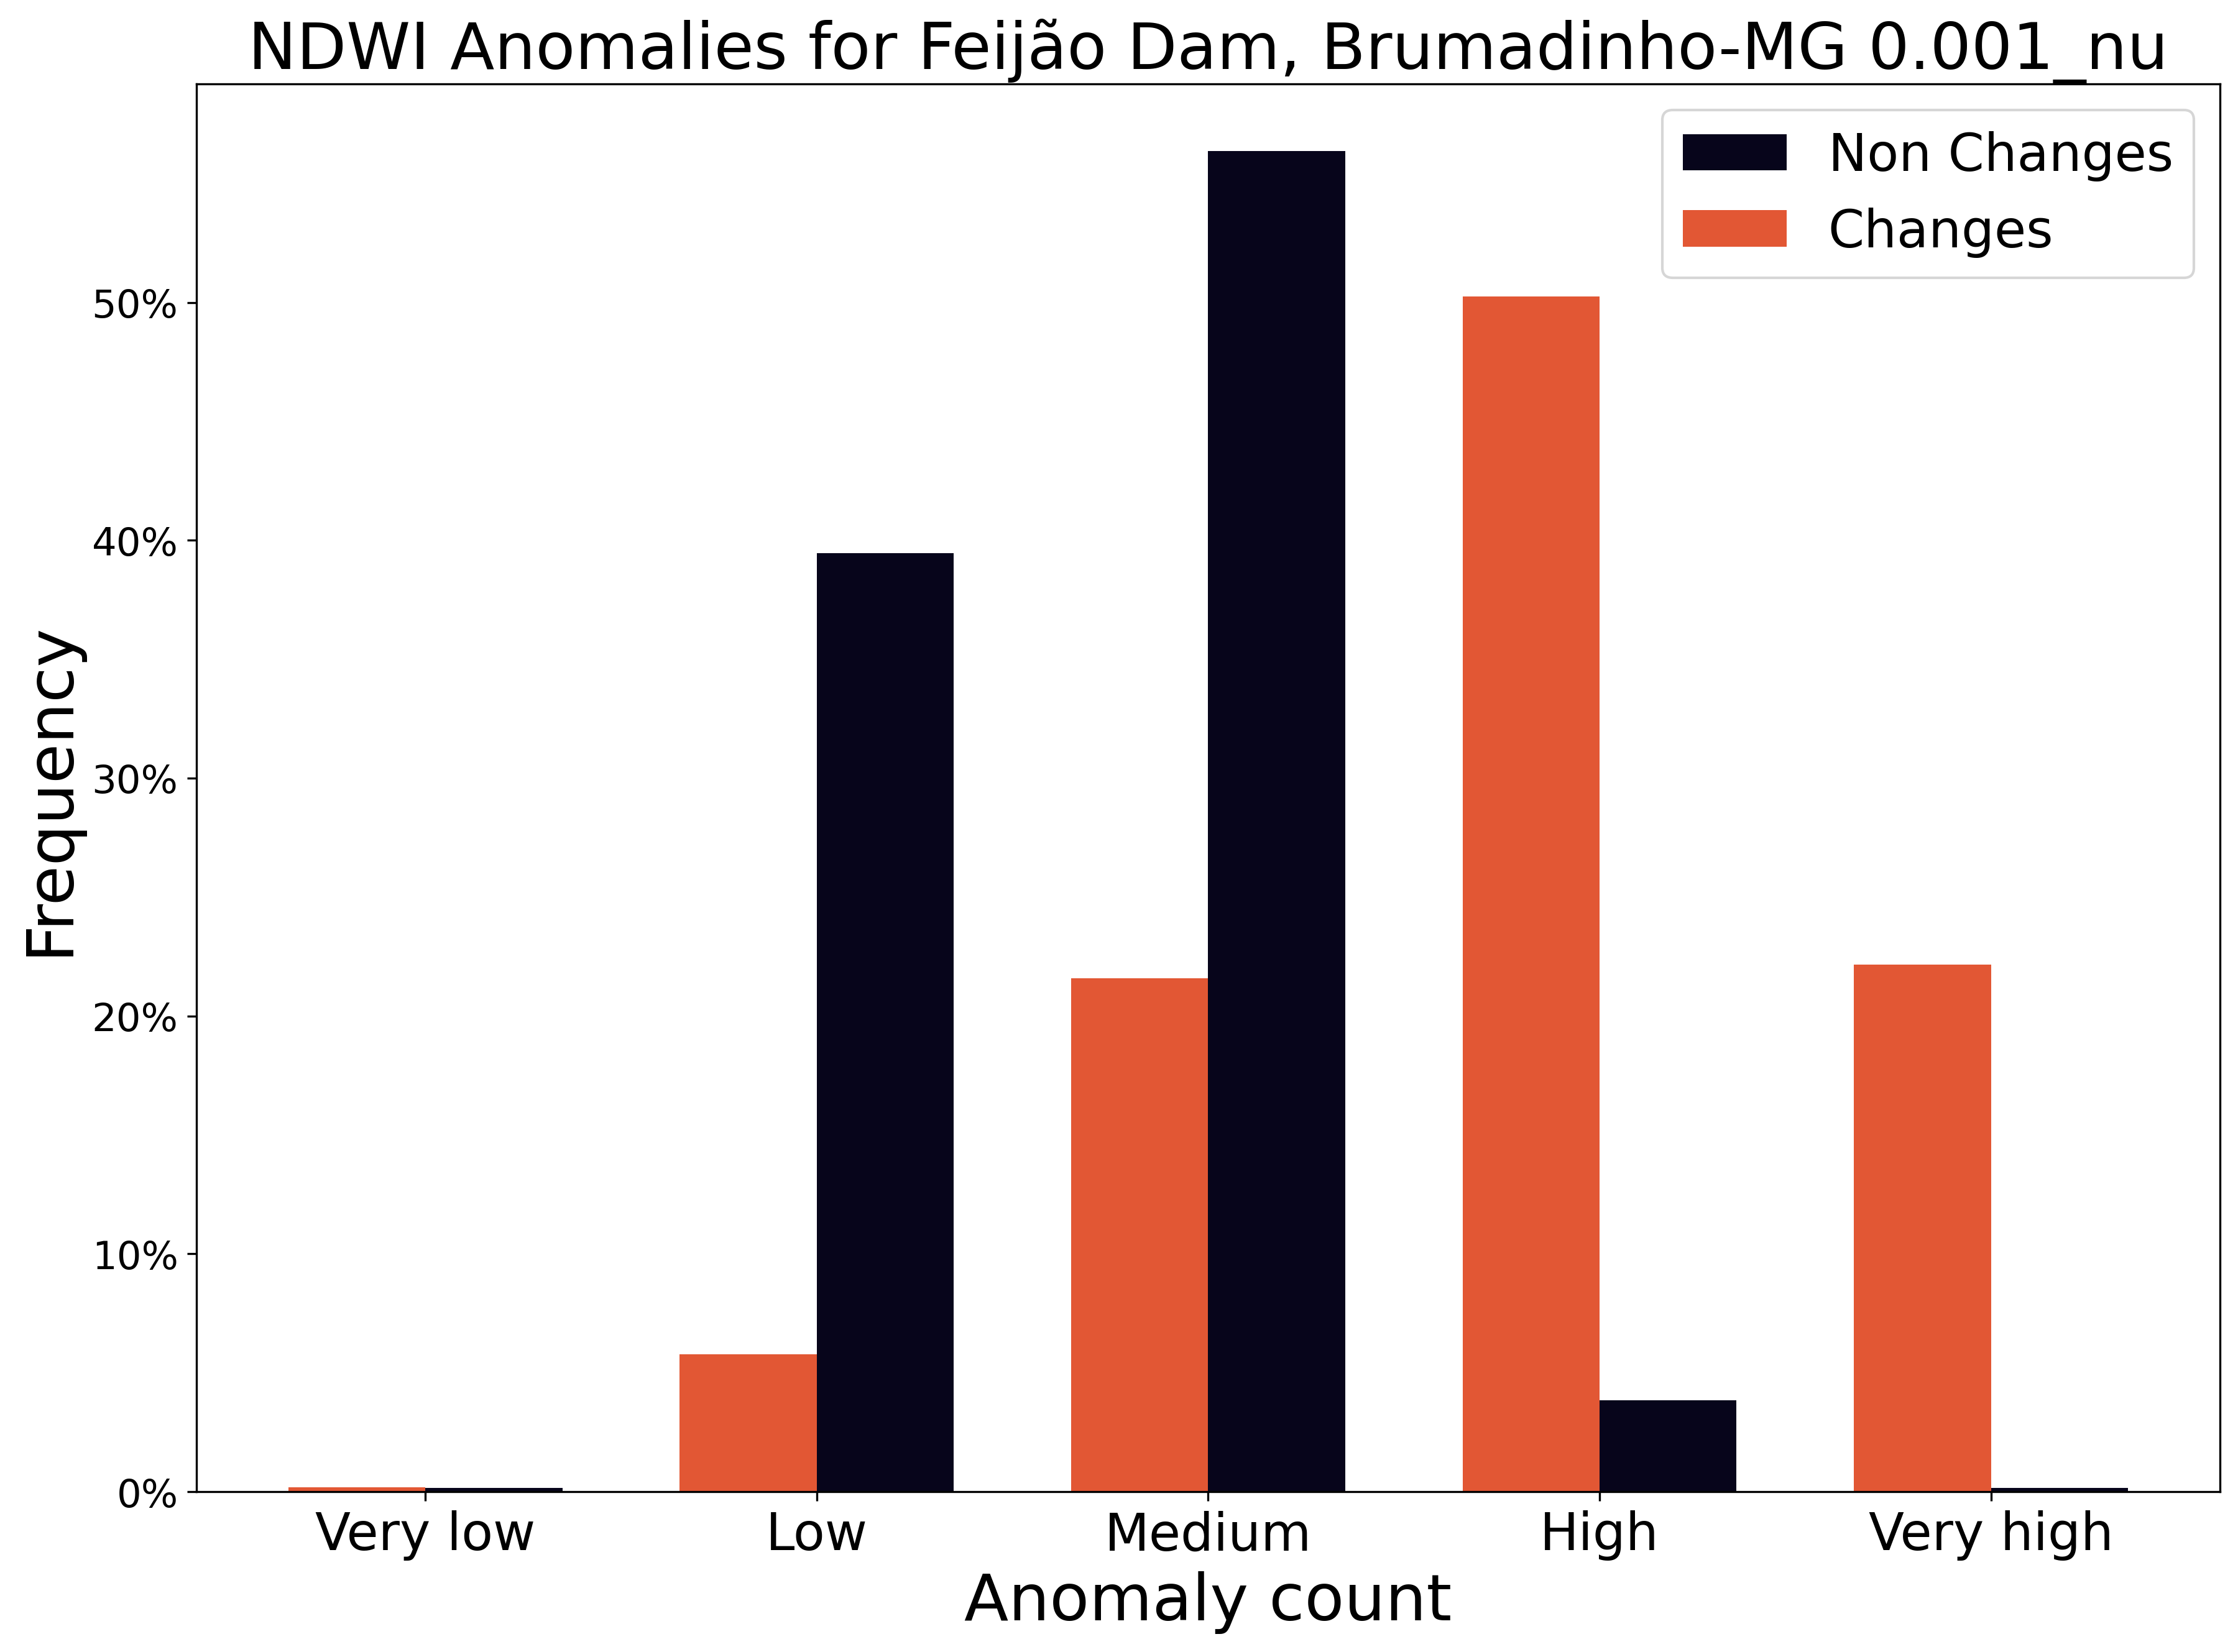

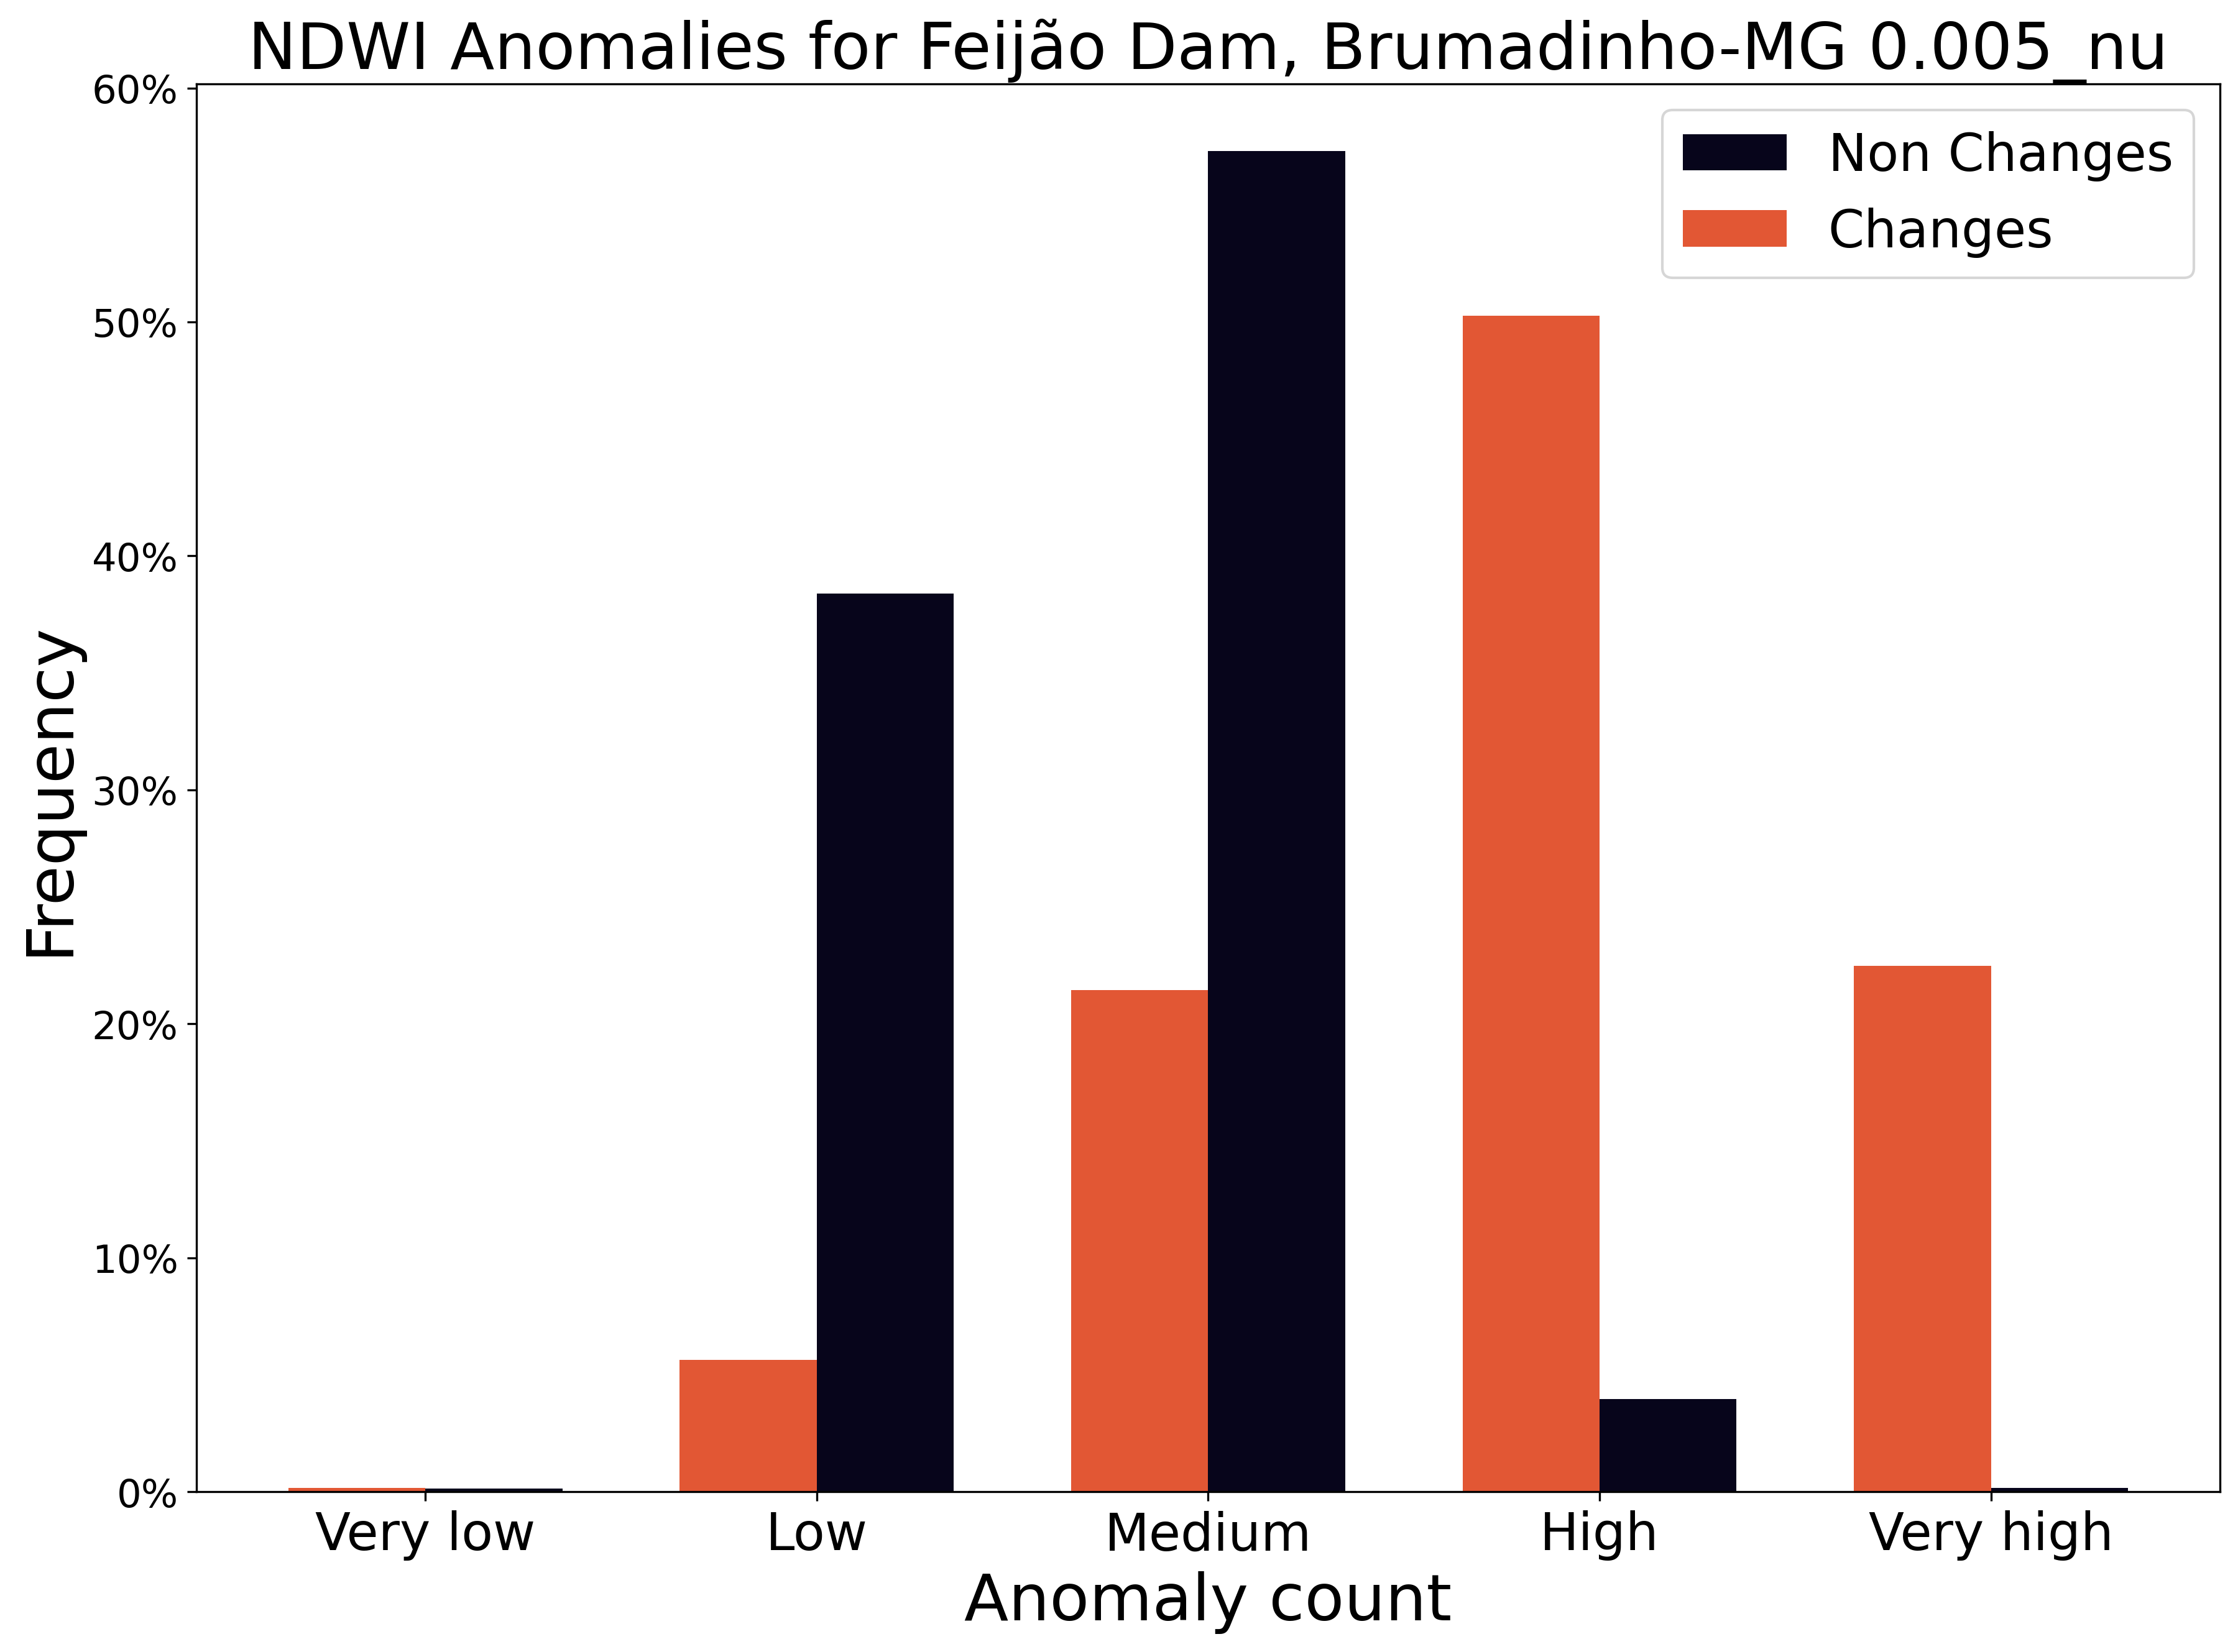

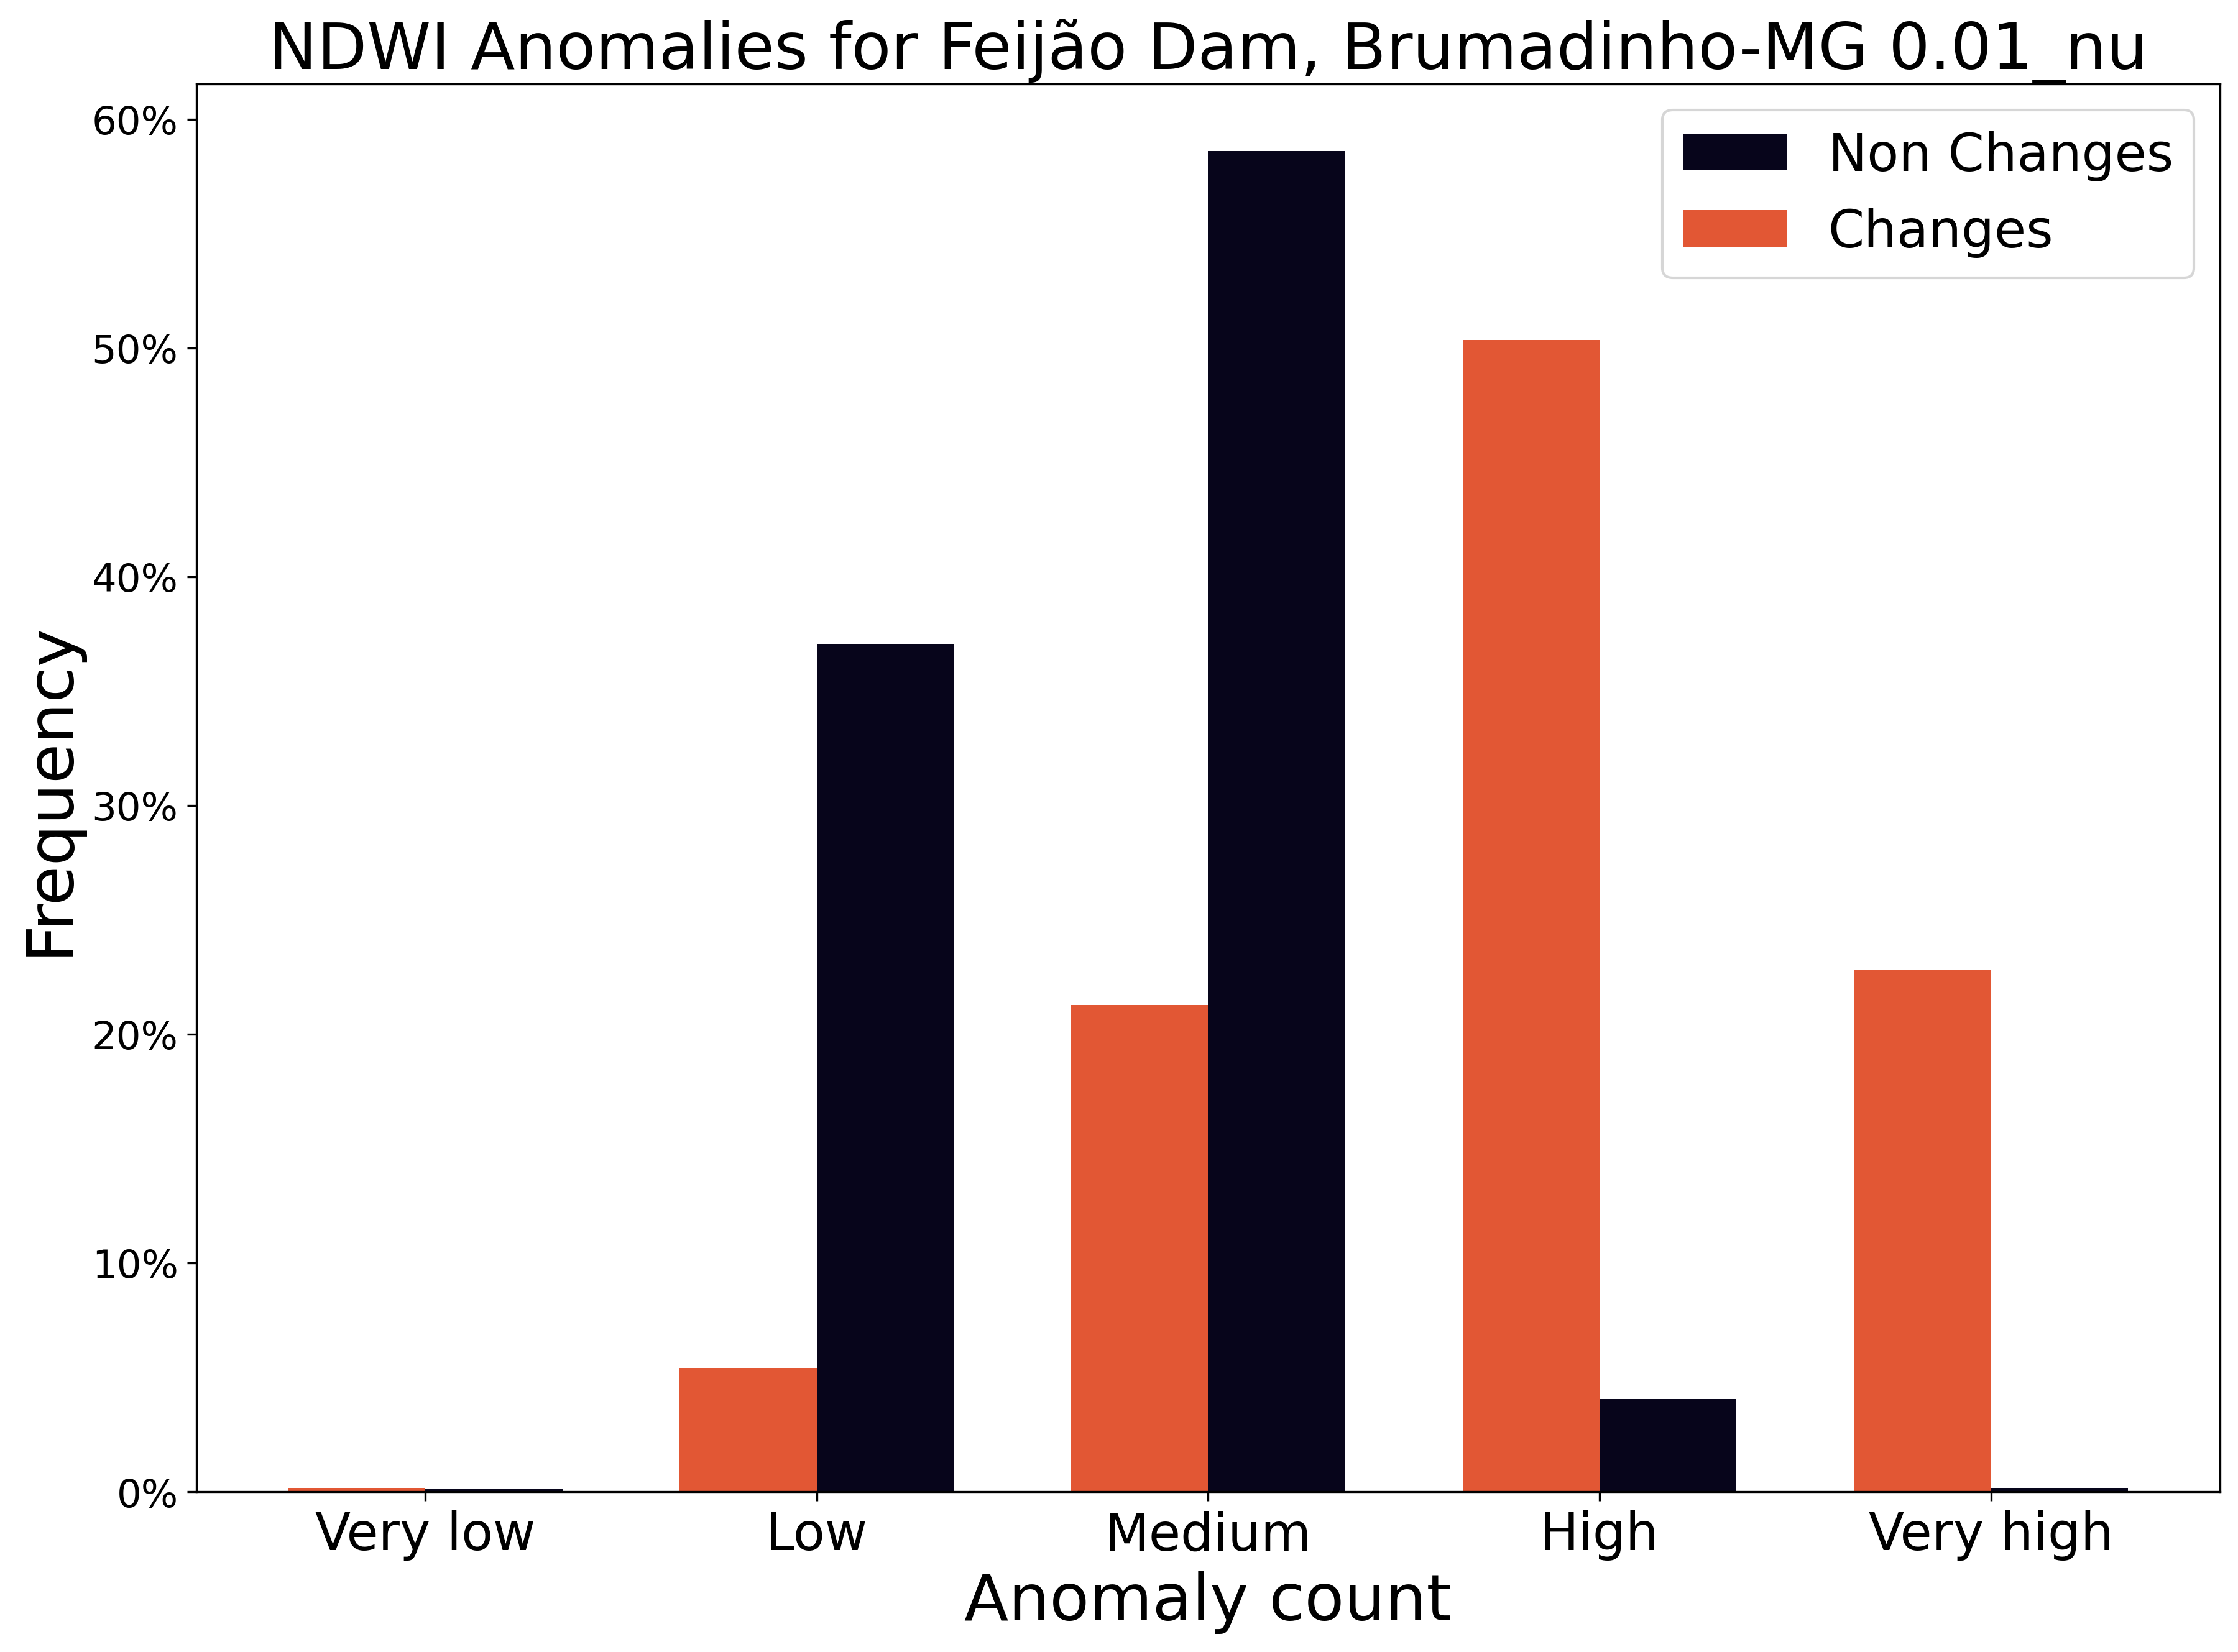

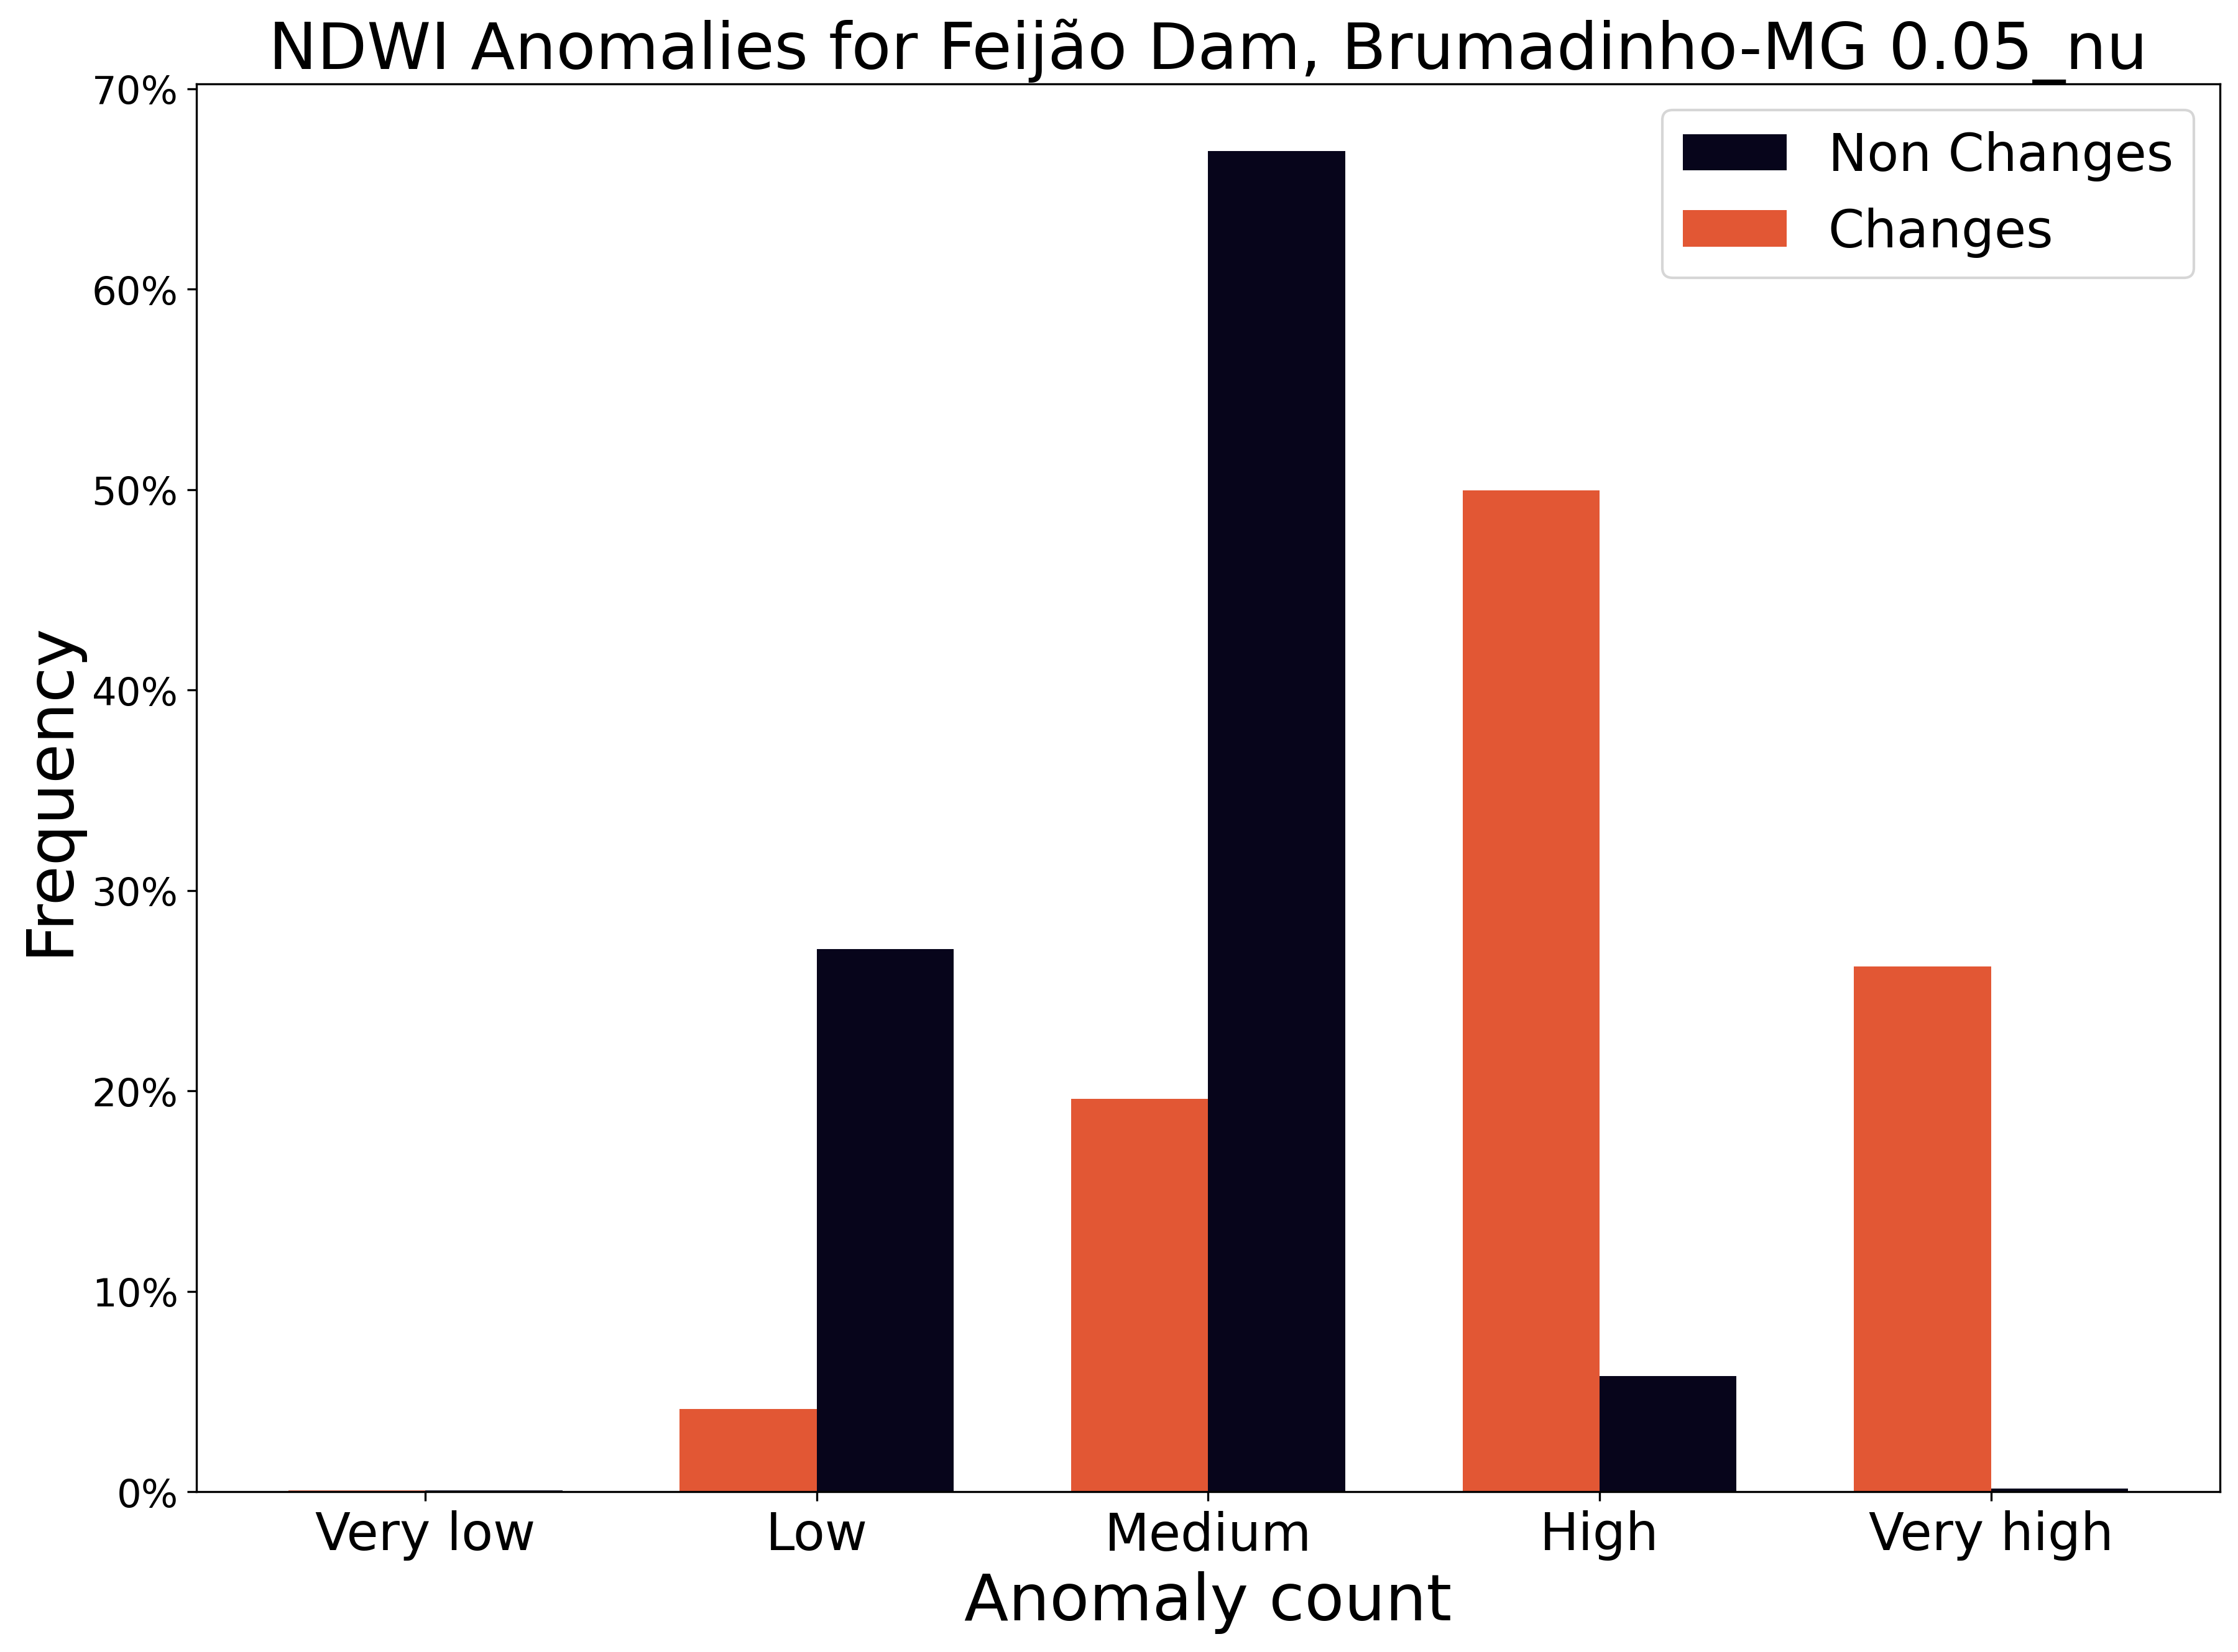

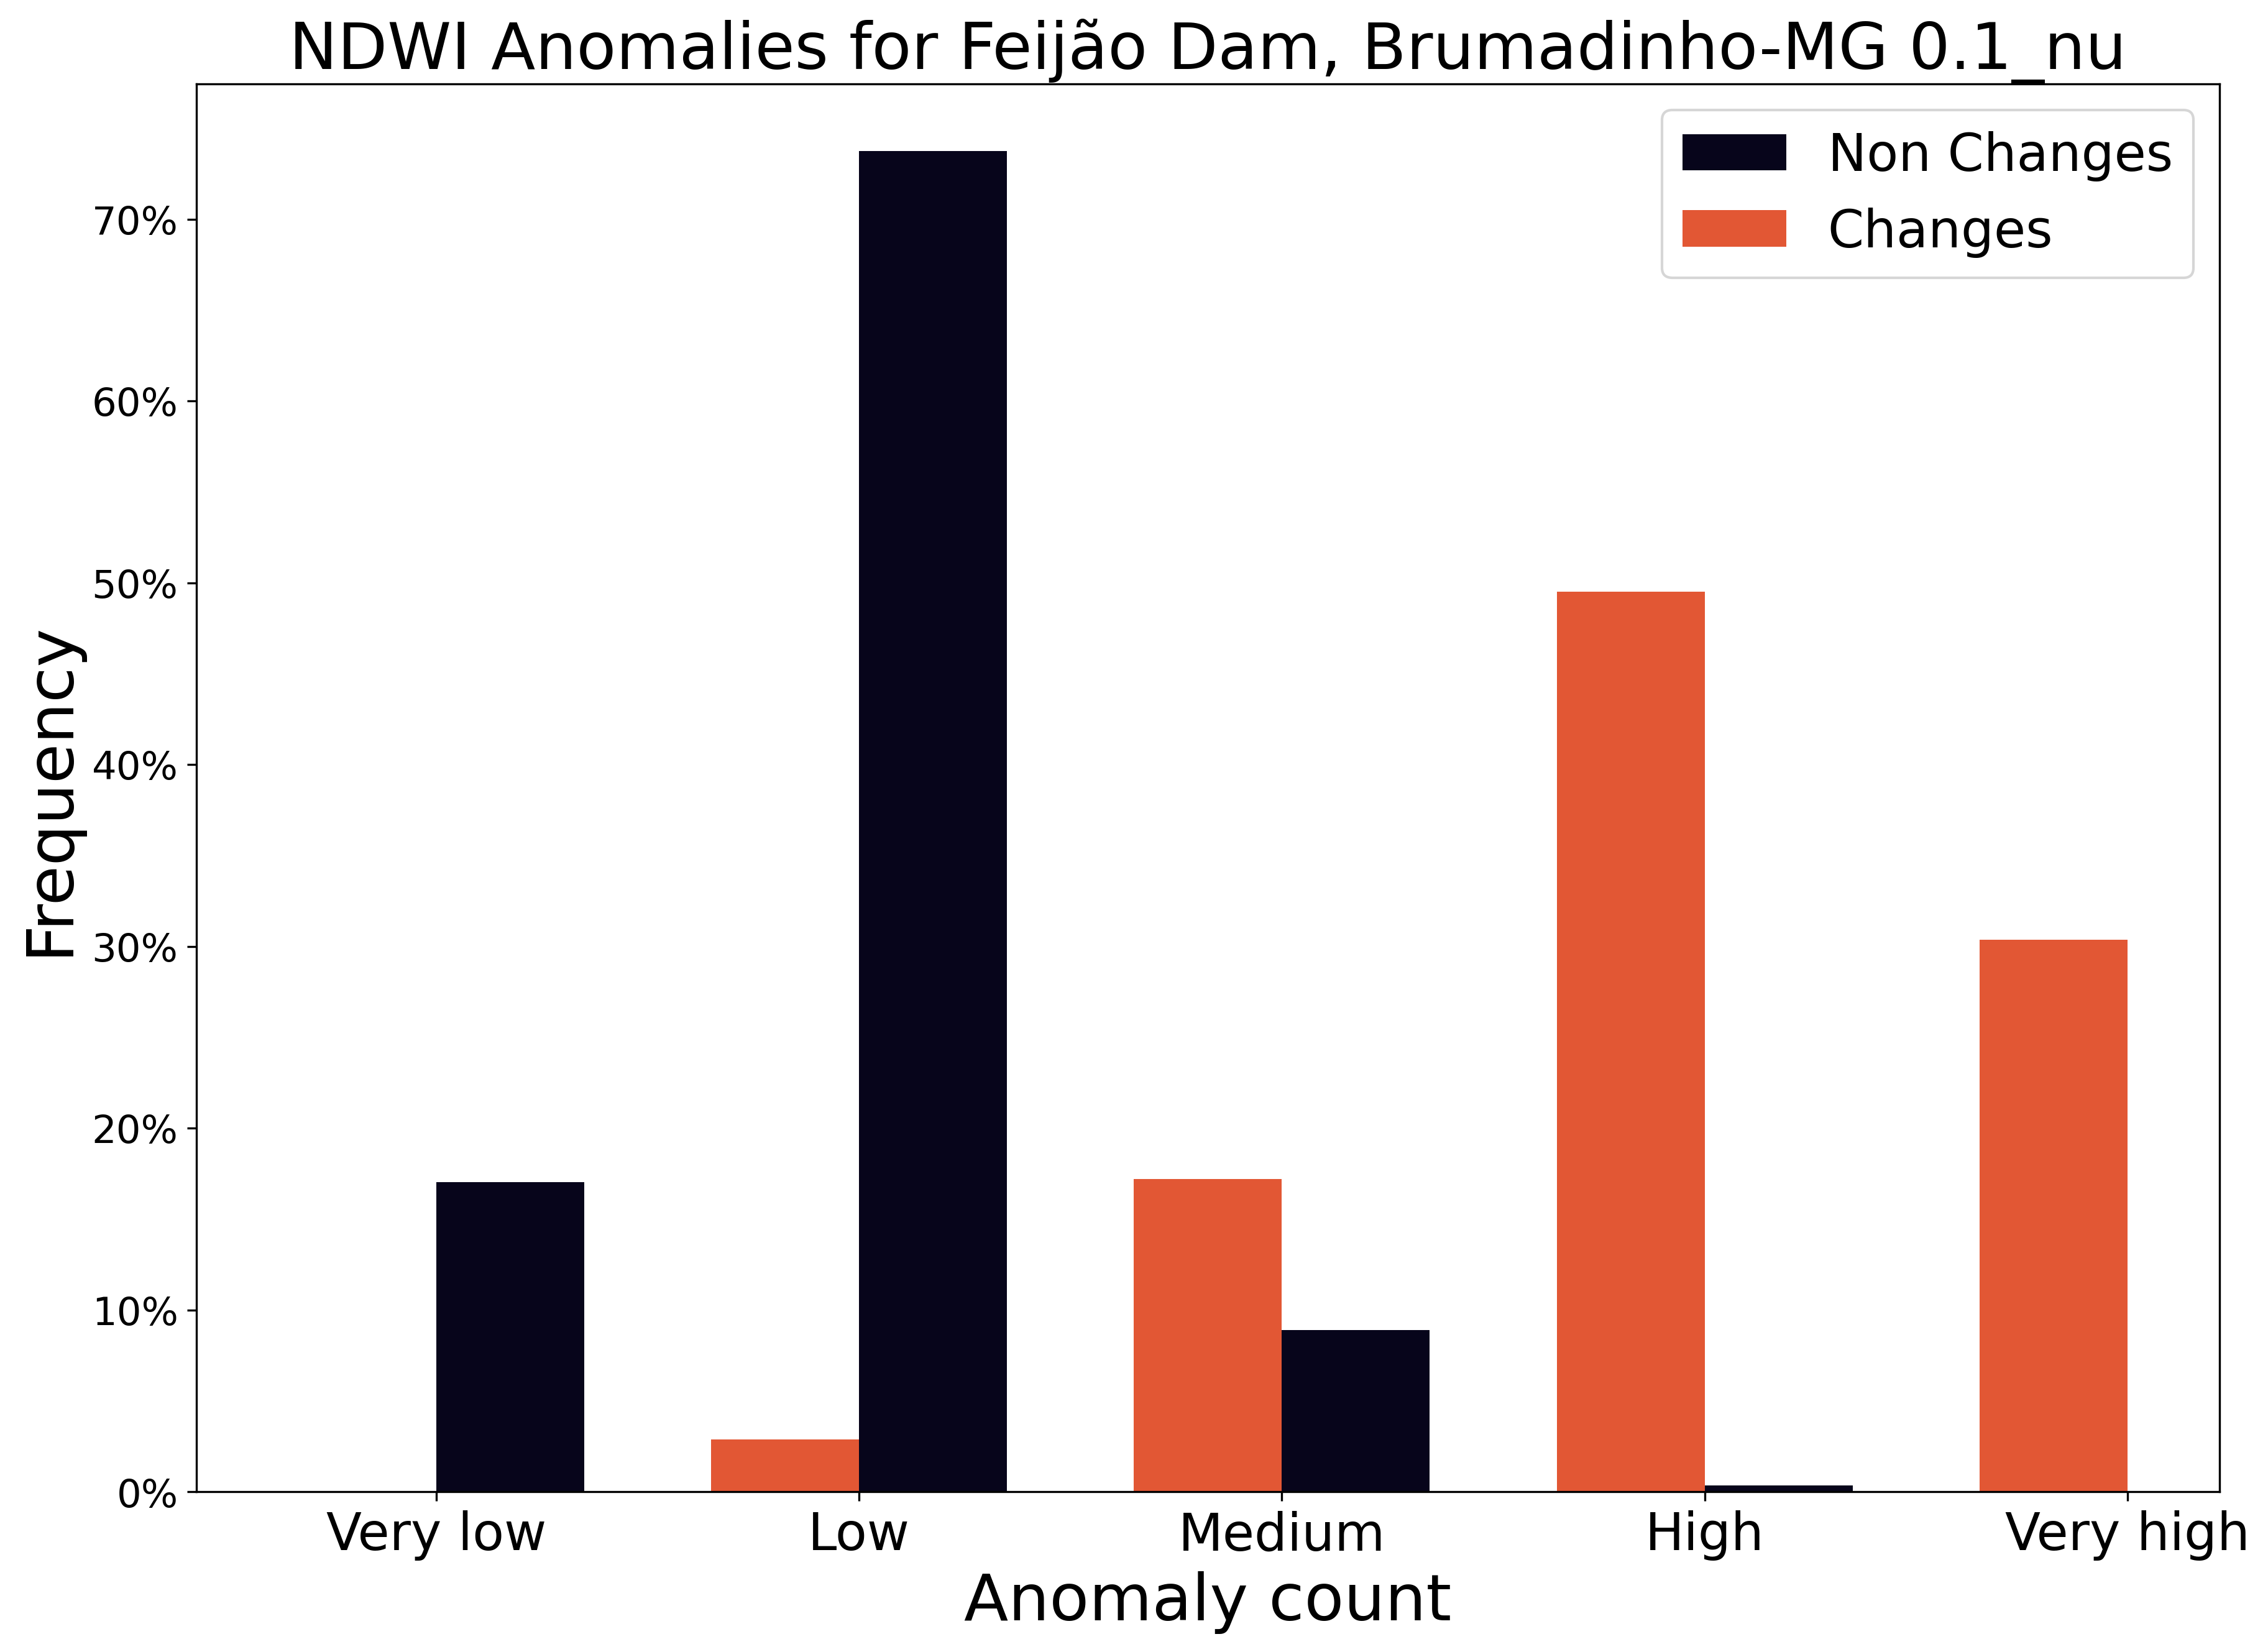

In [8]:
bru_shp_path_no = "../../../qgis/Barragens/Brumadinho/v2/unchangedareas_bru.shp"
dicionario_labels = {}
dt_dict_oc = {}

for t in dict_ocsvm_path:
    dfx, df1, df2 = gera_data(bru_shp_path,bru_shp_path_no,dict_ocsvm_path[t])
    dfoc_0 = aplica_labels(df1,64)
    nome1 = 'changes_' + str(t)
    dicionario_labels[nome1] = dfoc_0
    dfoc_1 = aplica_labels(df2,64)
    nome2 = 'unchanges_' + str(t) 
    dicionario_labels[nome2] = dfoc_1
    dt_dict_oc[t] = dfx
    histo_gera(dfoc_0,dfoc_1,t)
    plt.show()

In [9]:
titles = list(dicionario_labels.keys())
uy2 = pd.DataFrame()
for i in titles:
    okl = dicionario_labels[i]['label'].value_counts()
    t = okl.sum()
    okl = okl/t
    uy = pd.DataFrame(okl)
    uy = uy.fillna(0)
    uy = uy.set_axis([i], axis=1, inplace=False)
    uy2 = pd.concat([uy,uy2], axis=1)
    
saida = uy2.fillna(0)
saida

,unchanges_0.1_nu,changes_0.1_nu,unchanges_0.05_nu,changes_0.05_nu,unchanges_0.01_nu,changes_0.01_nu,unchanges_0.005_nu,changes_0.005_nu,unchanges_0.001_nu,changes_0.001_nu
Medium,0.737446,0.172112,0.668986,0.196023,0.586045,0.212753,0.573068,0.214505,0.563664,0.215994
Low,0.170397,0.028729,0.270829,0.041342,0.370510,0.054042,0.384051,0.056320,0.394583,0.057896
High,0.088772,0.495139,0.057739,0.499693,0.040436,0.503547,0.039684,0.502584,0.038556,0.502584
Very high,0.003385,0.303758,0.001693,0.262241,0.001693,0.228081,0.001693,0.224840,0.001505,0.221687
Very low,0.000000,0.000263,0.000752,0.000701,0.001317,0.001577,0.001505,0.001752,0.001693,0.001839


In [10]:
saida.to_csv('../../Brumadinho/csv/hist_bars_OCSVM_Bru.csv')

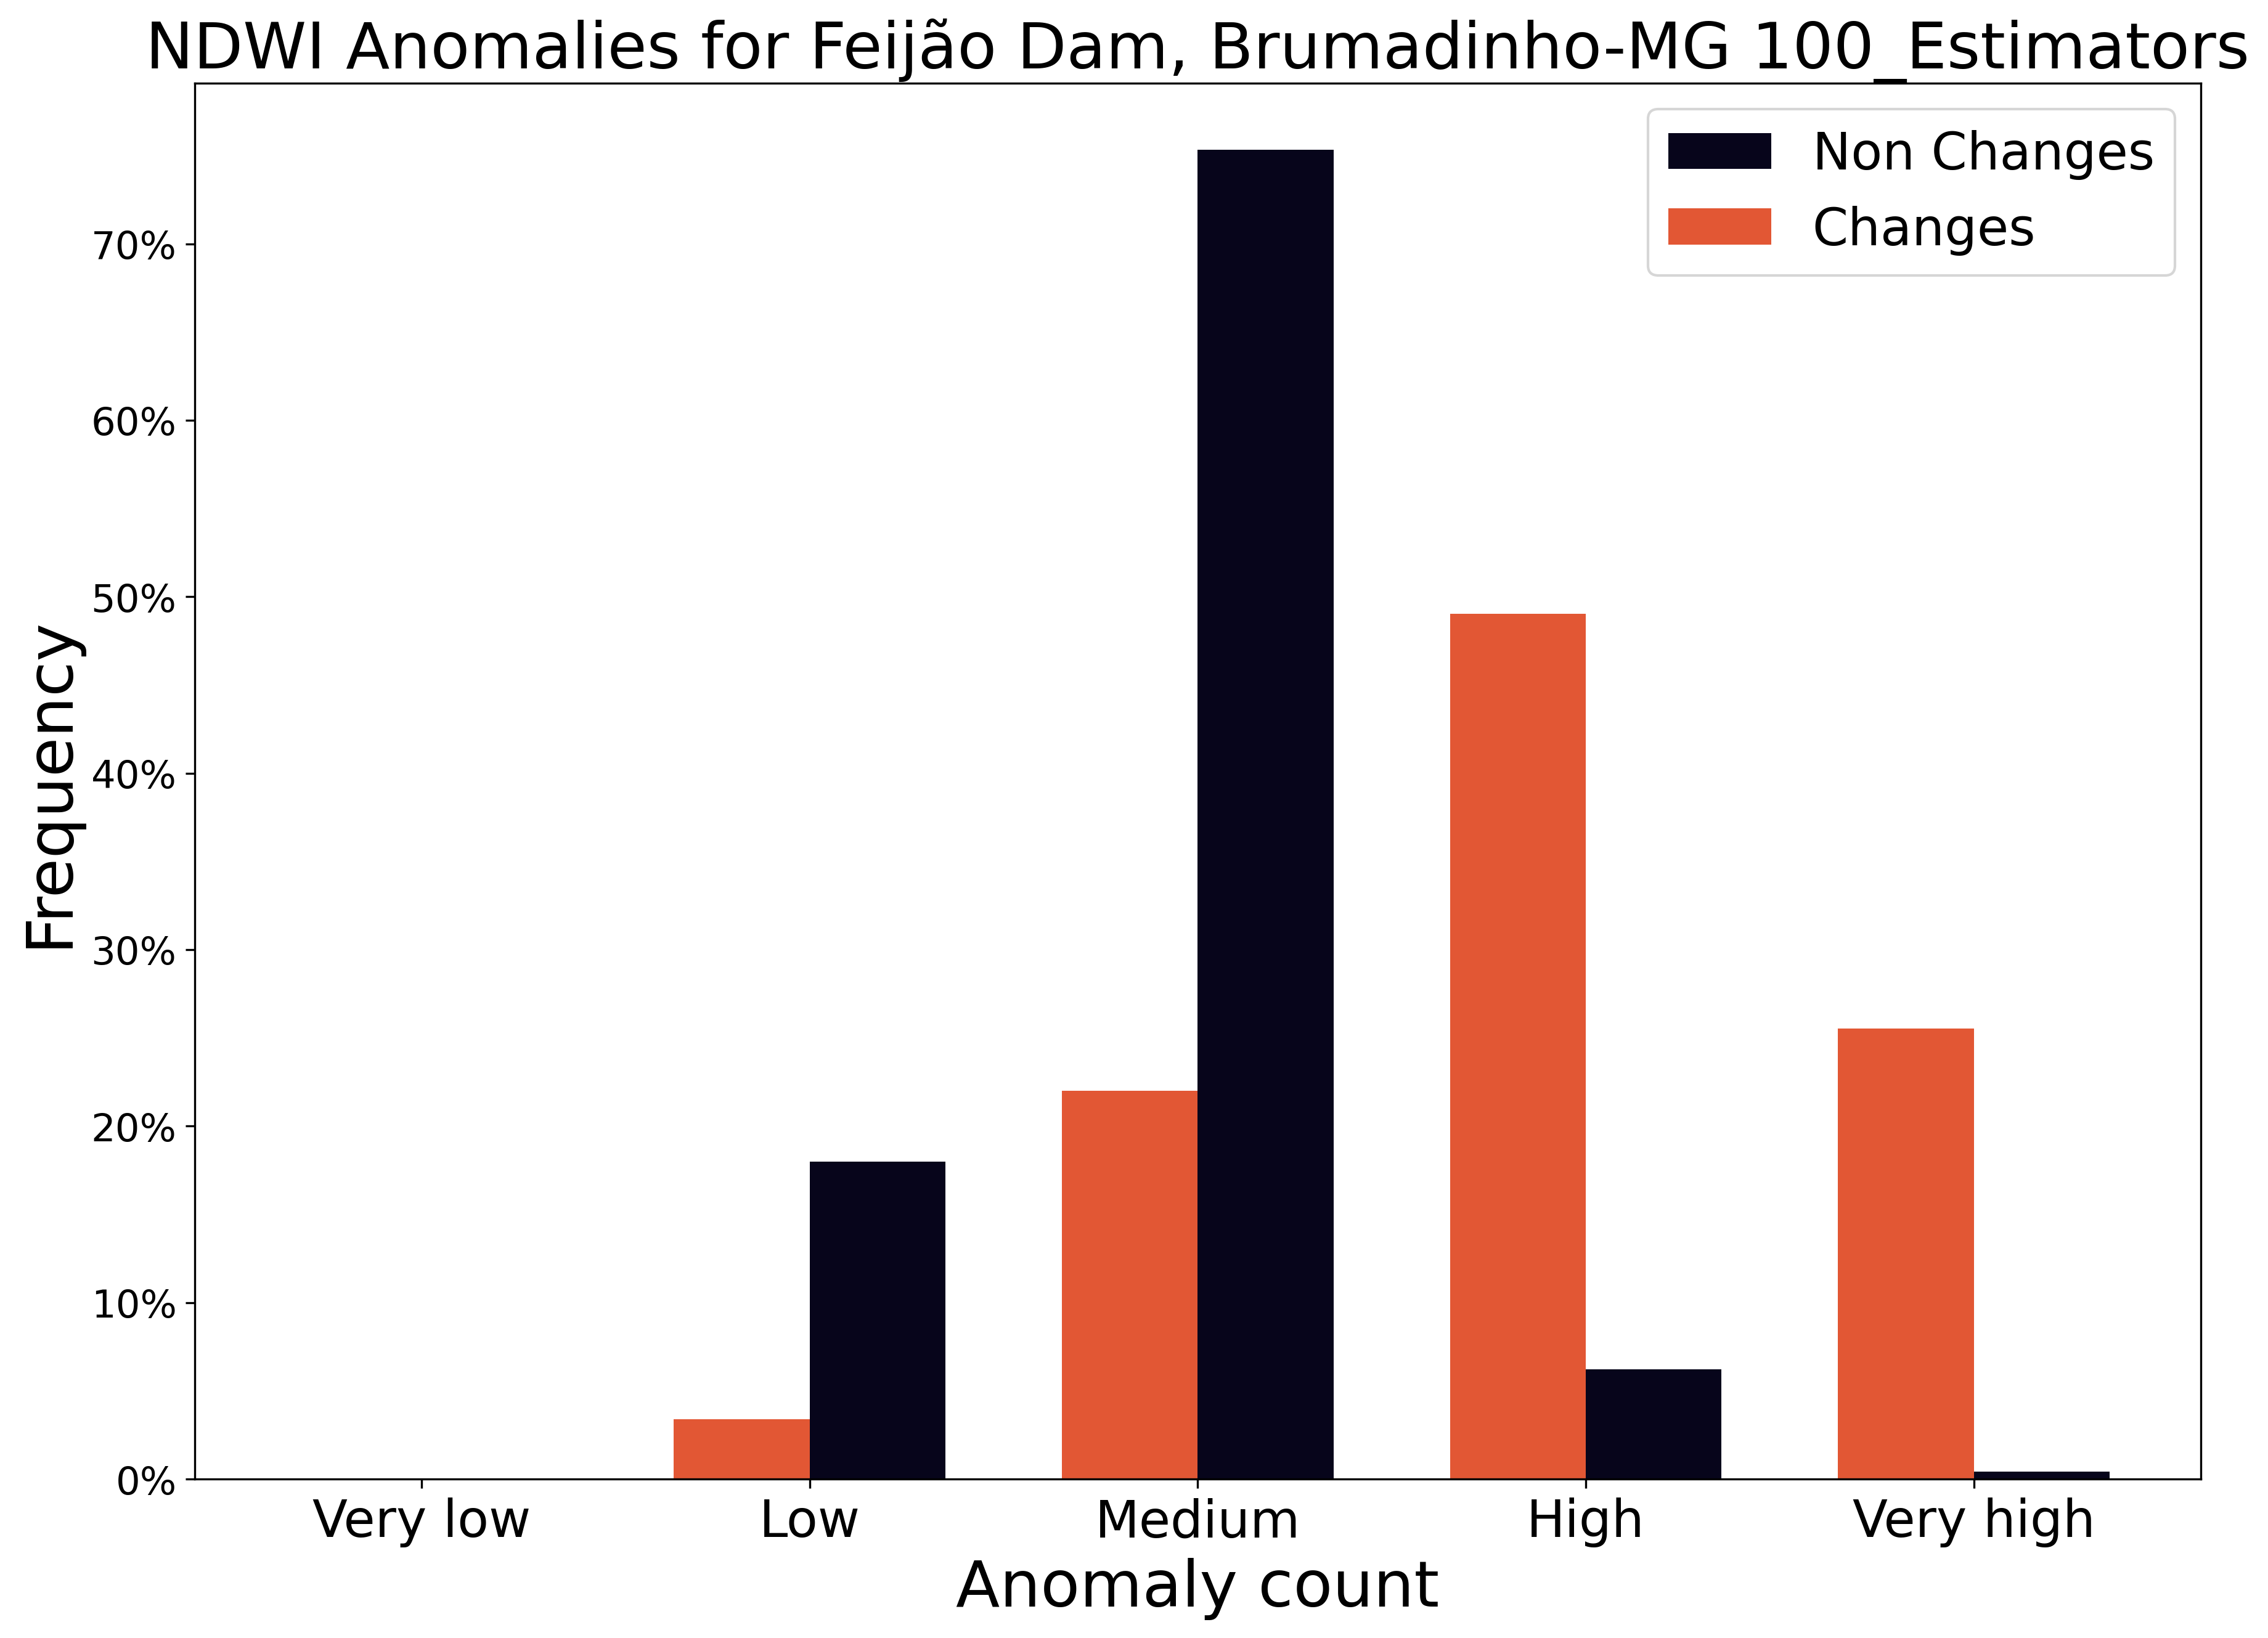

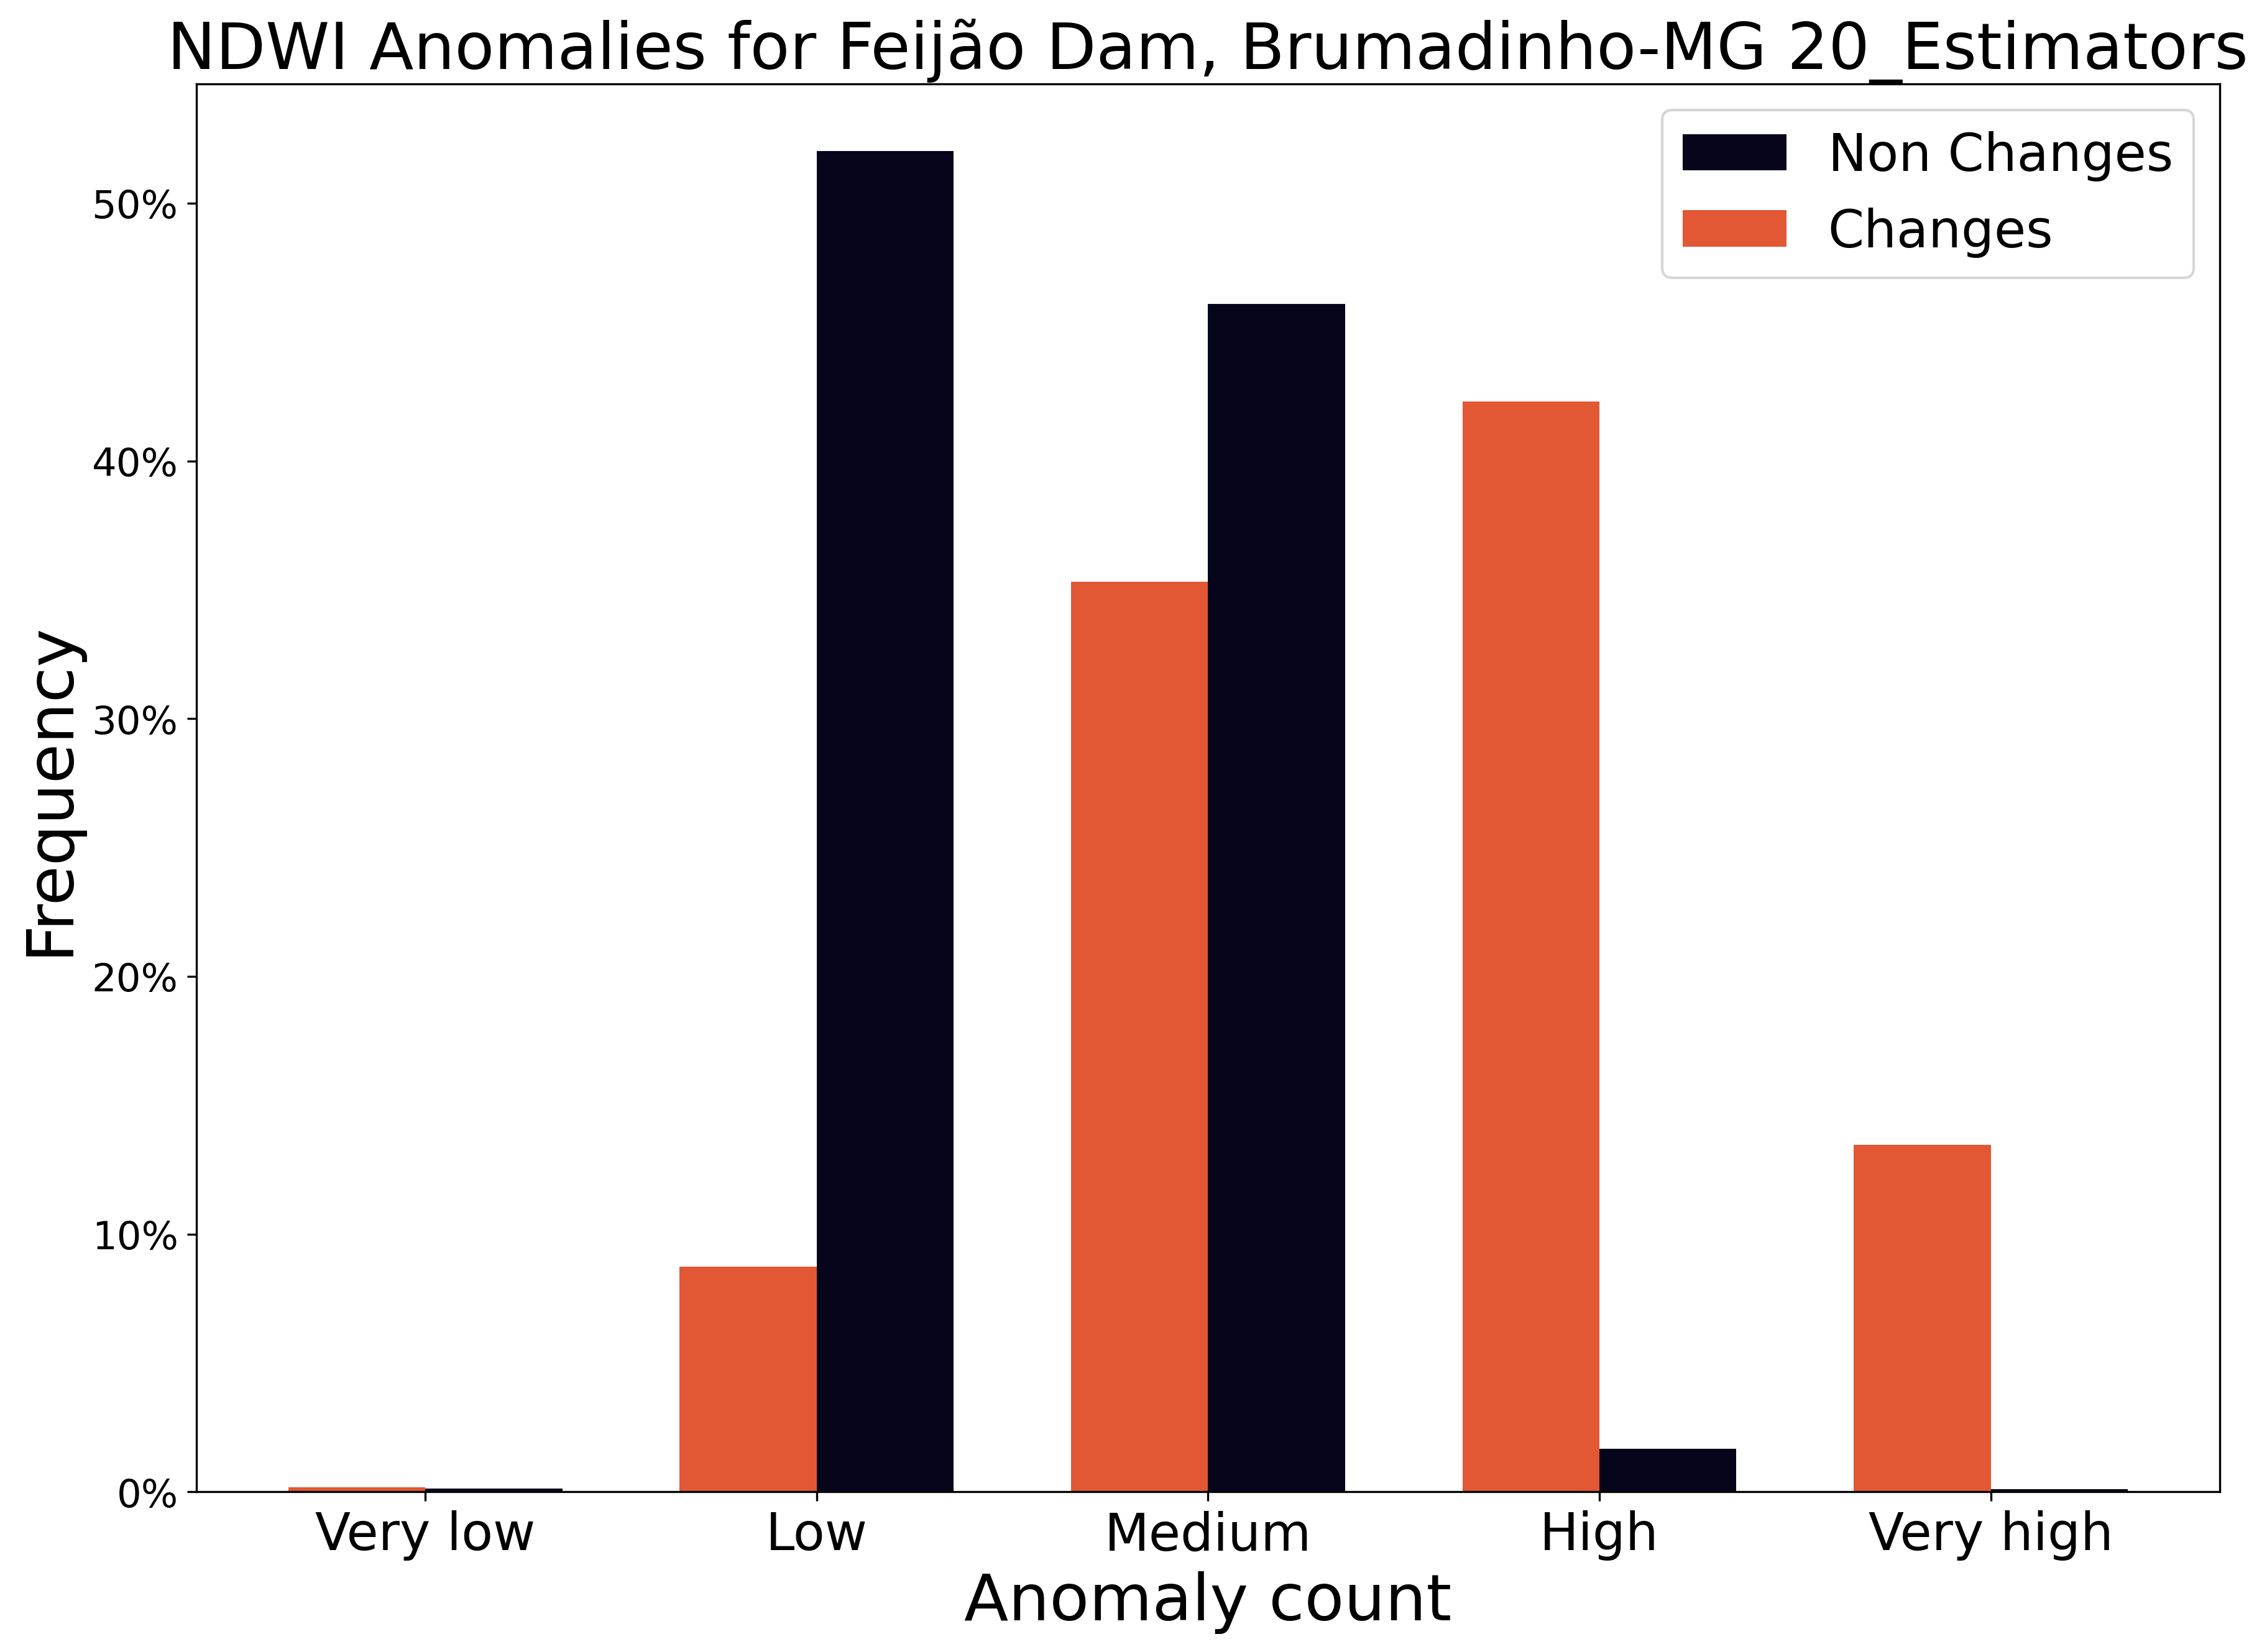

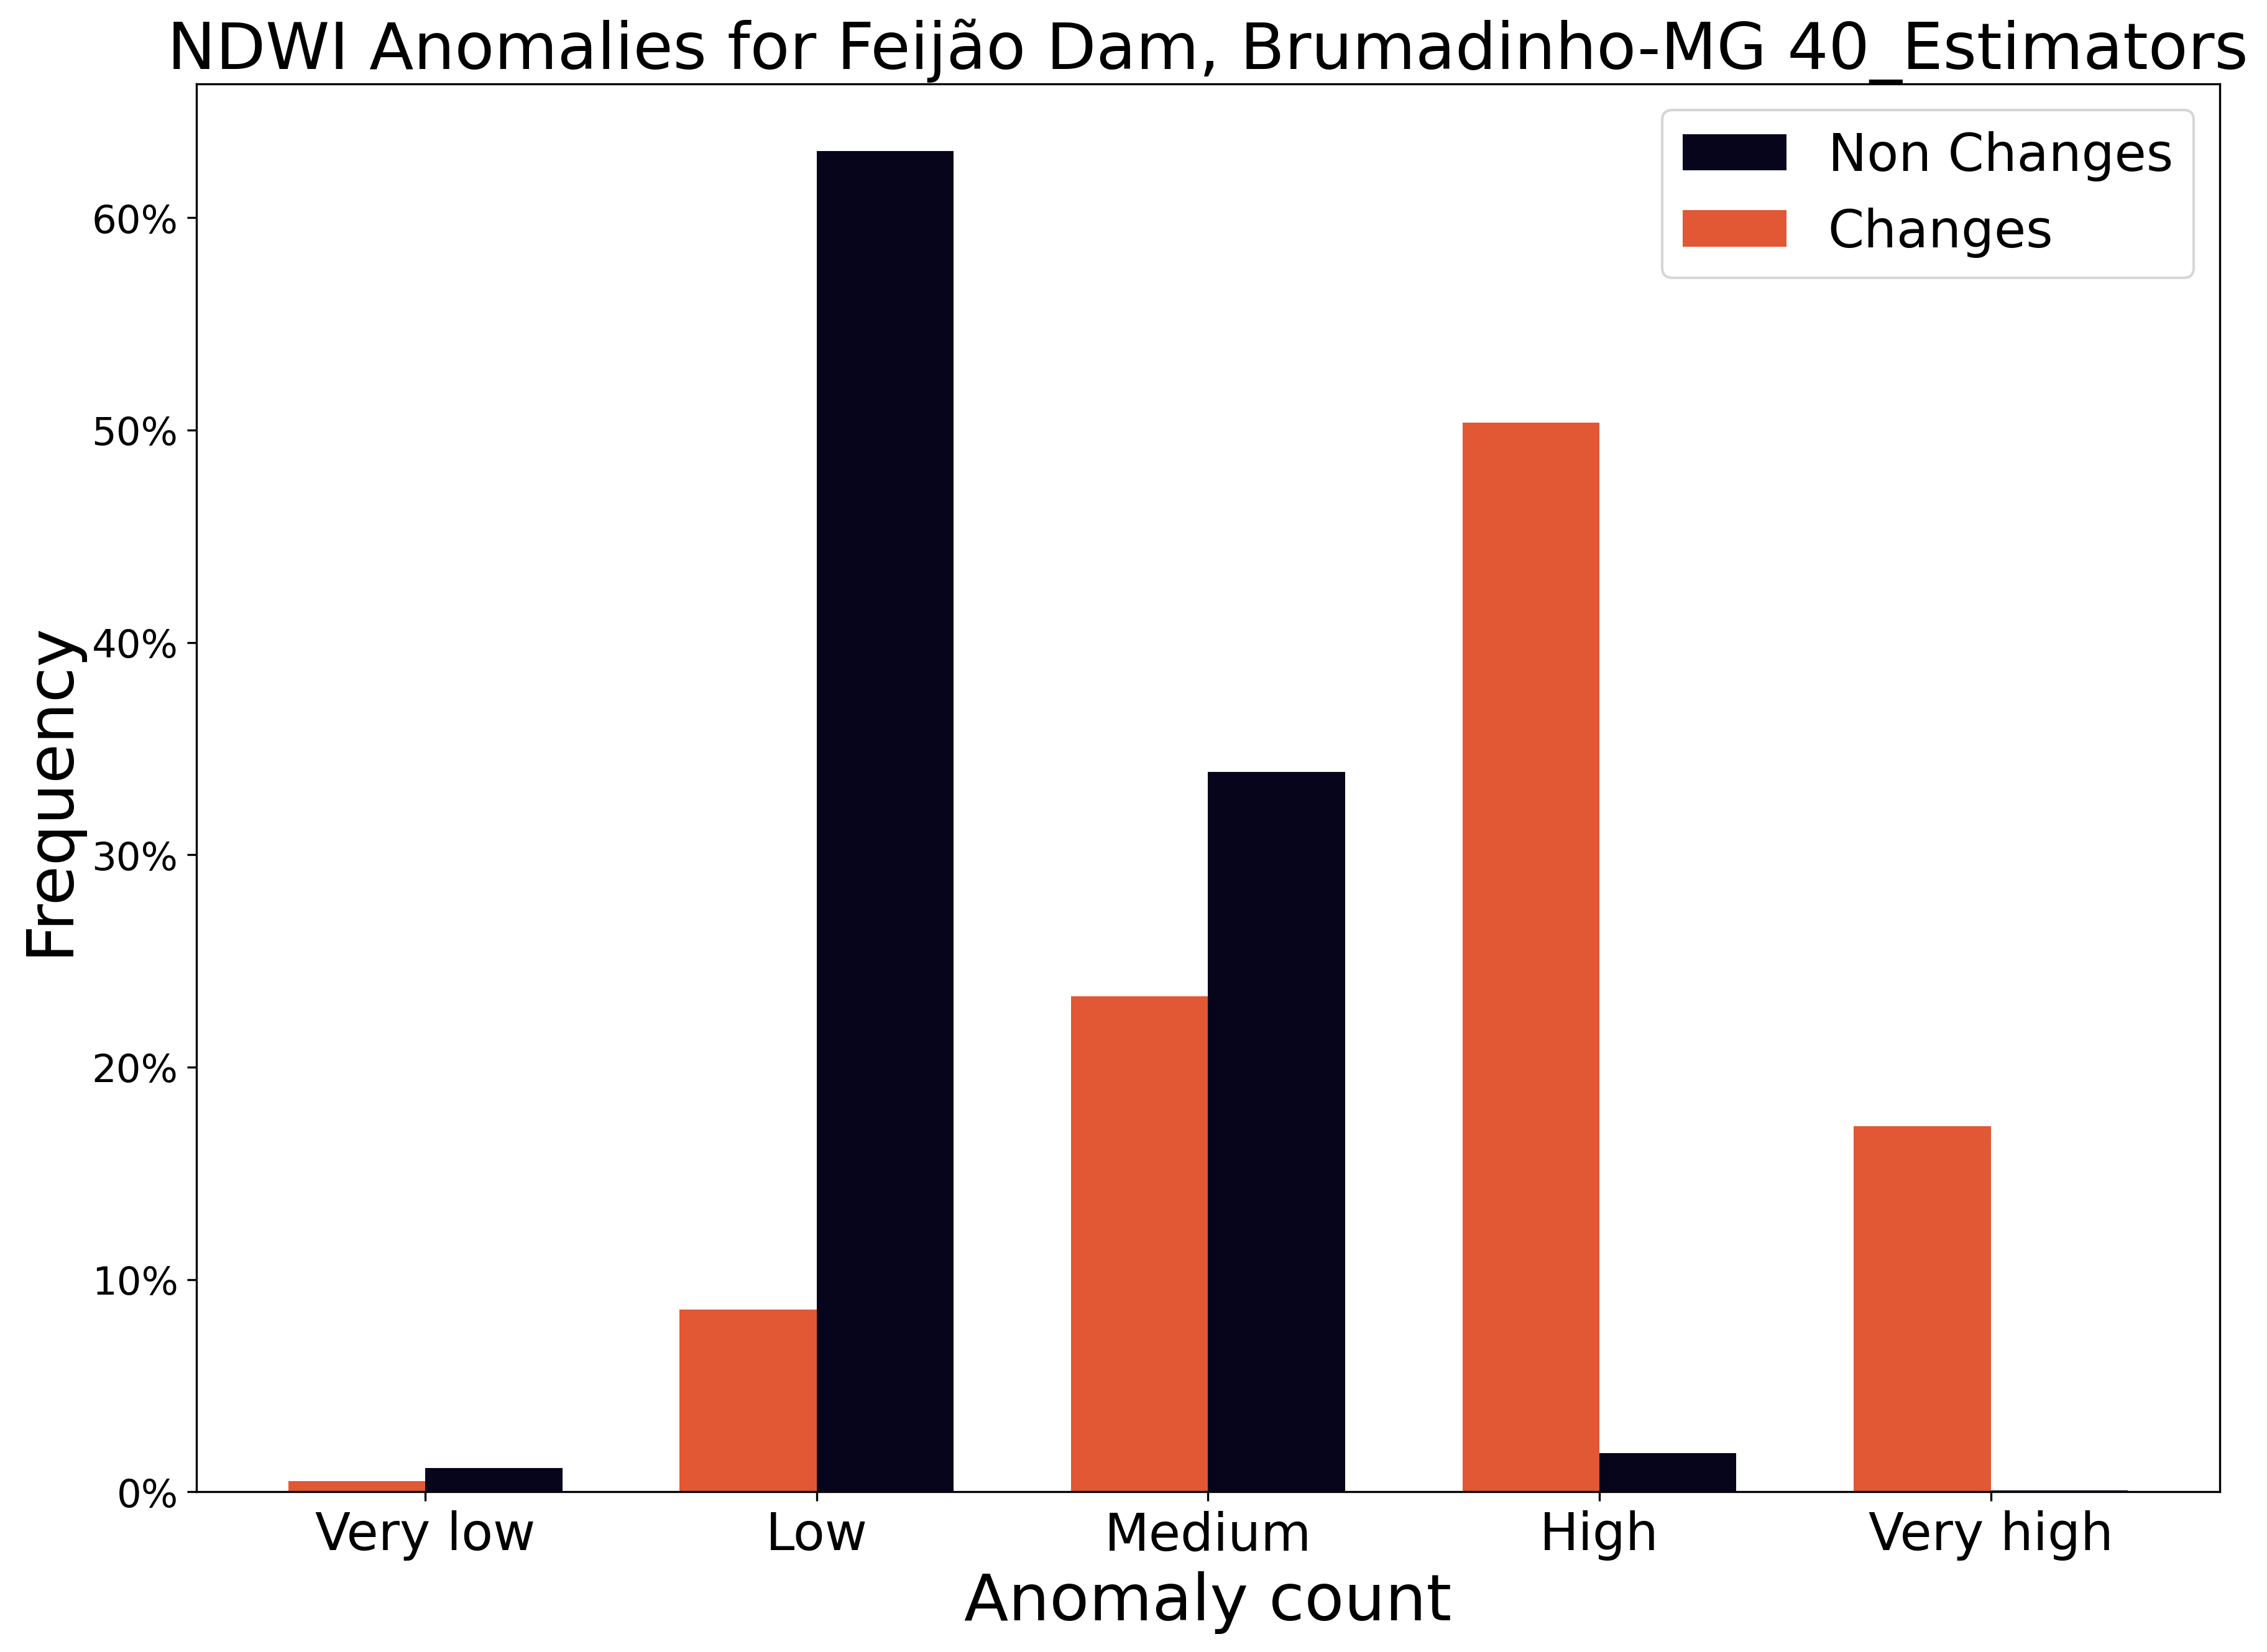

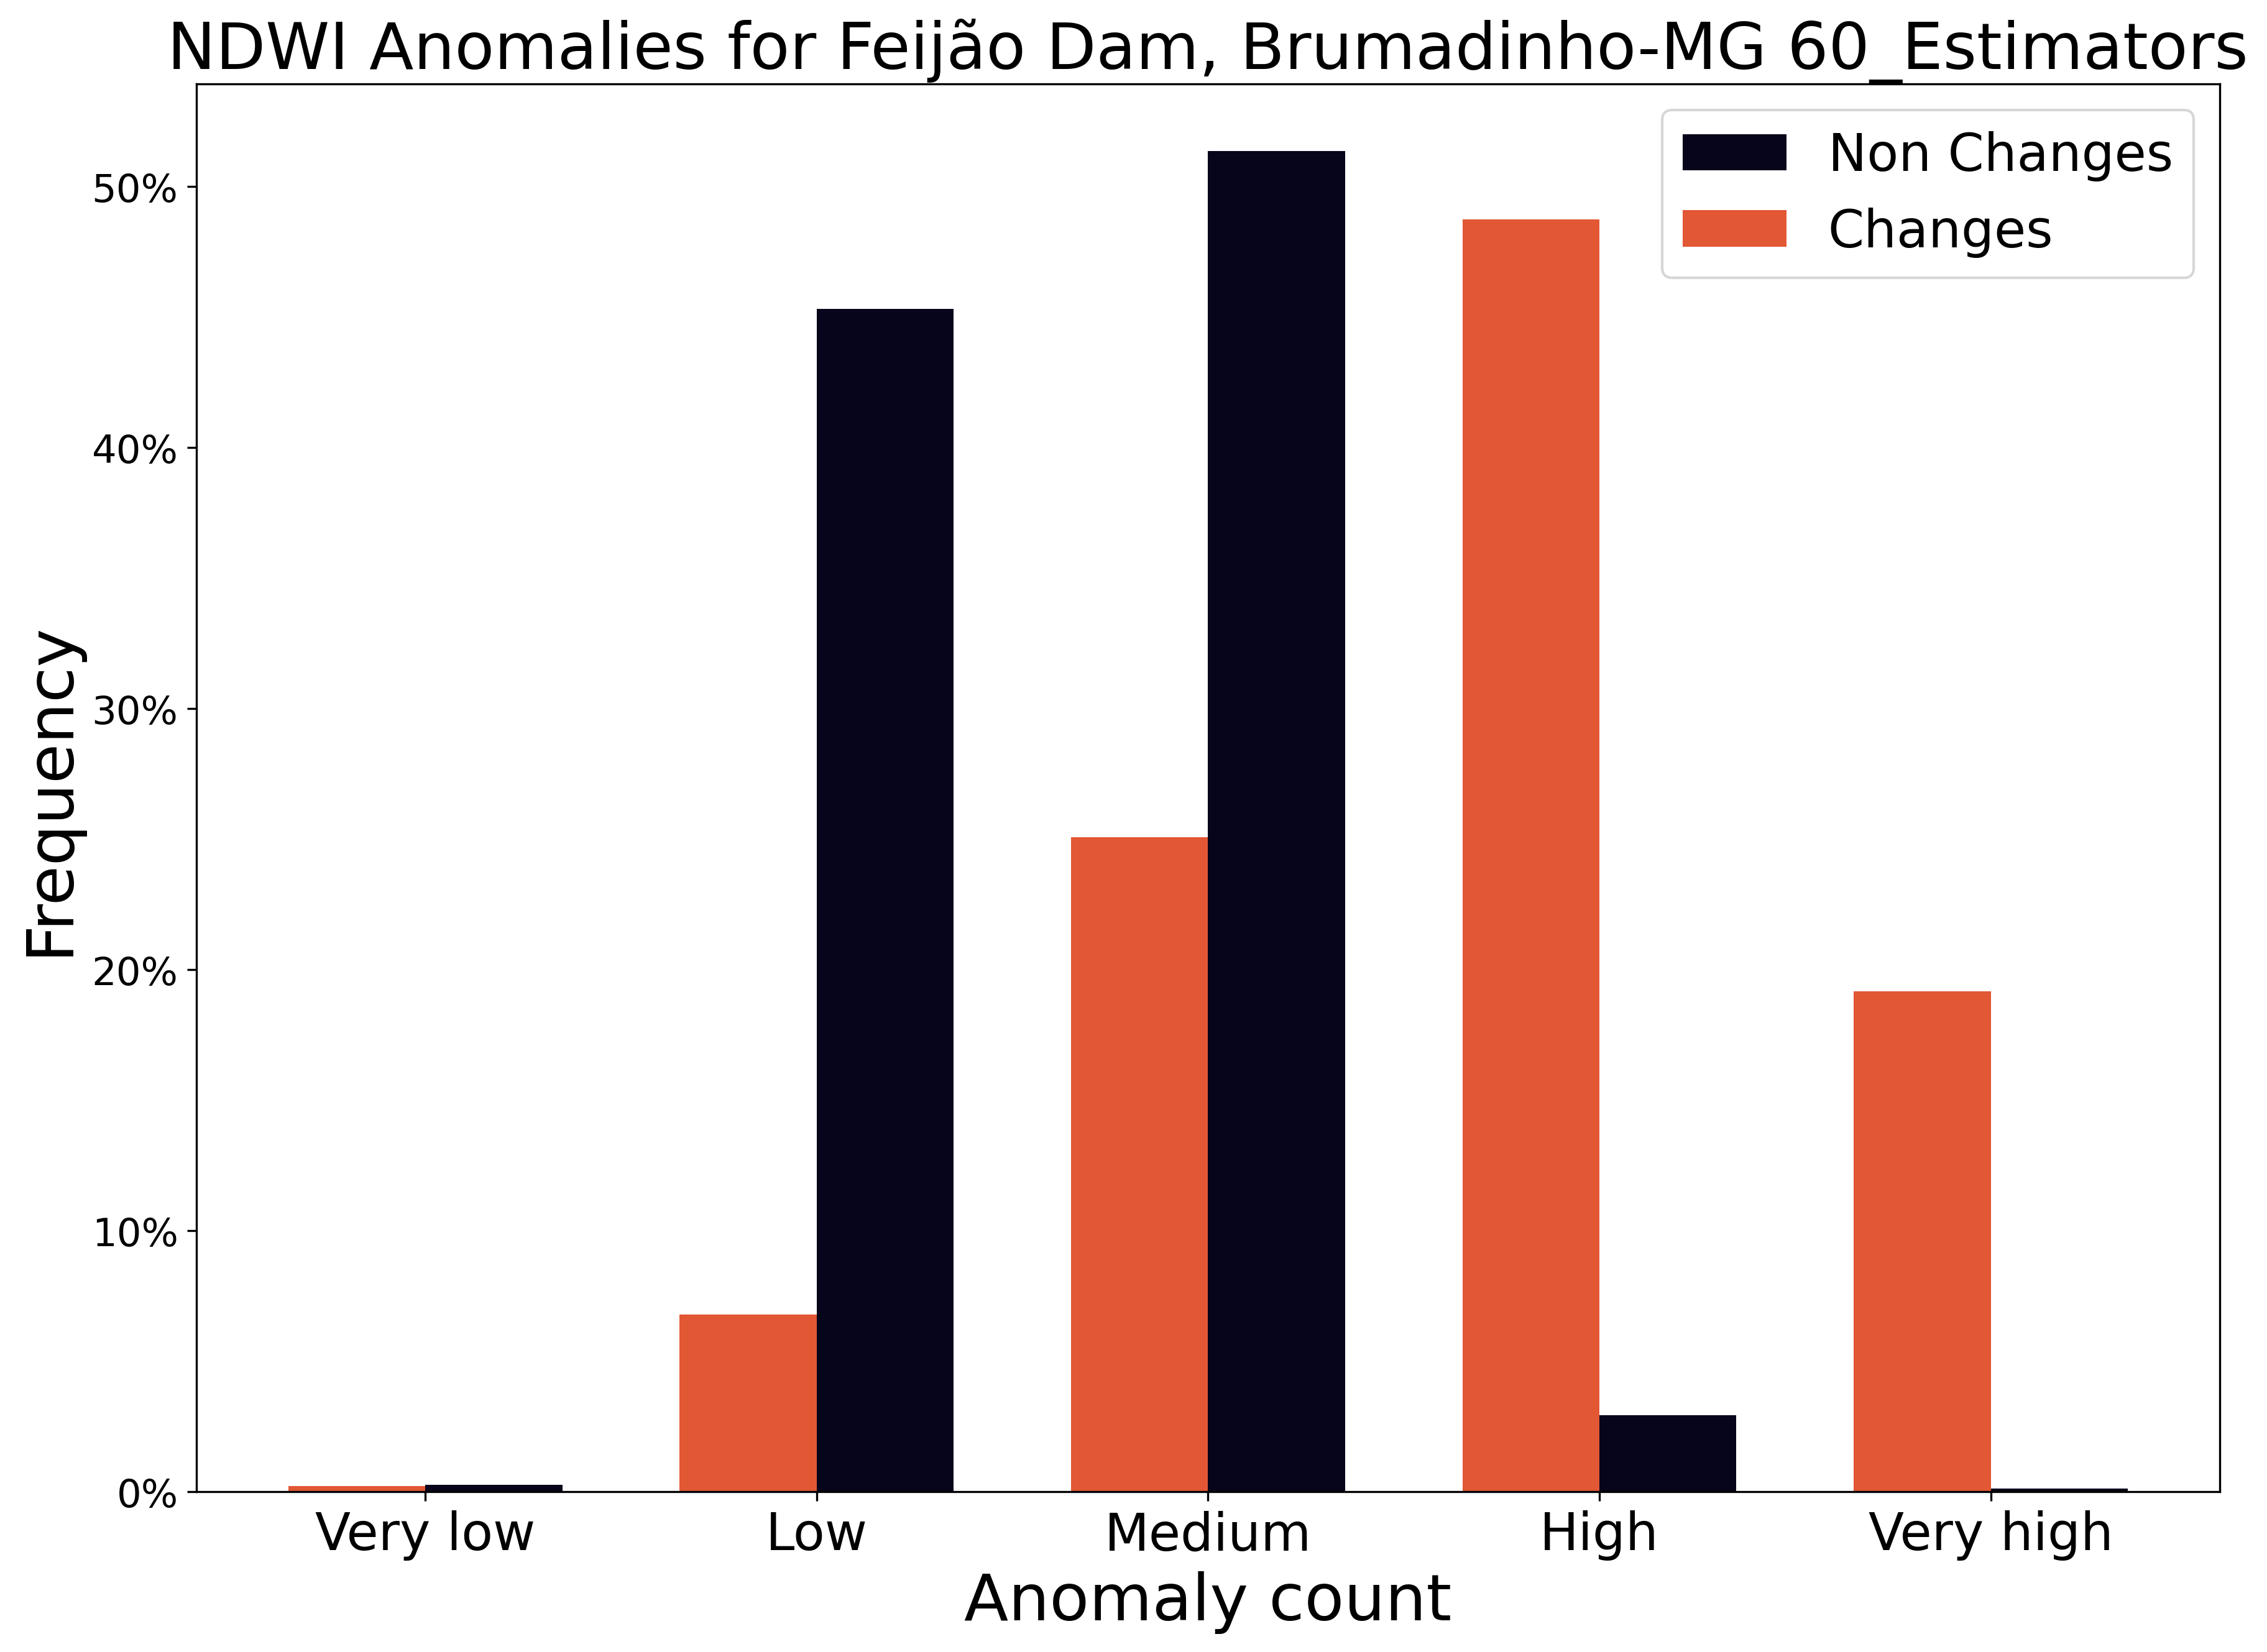

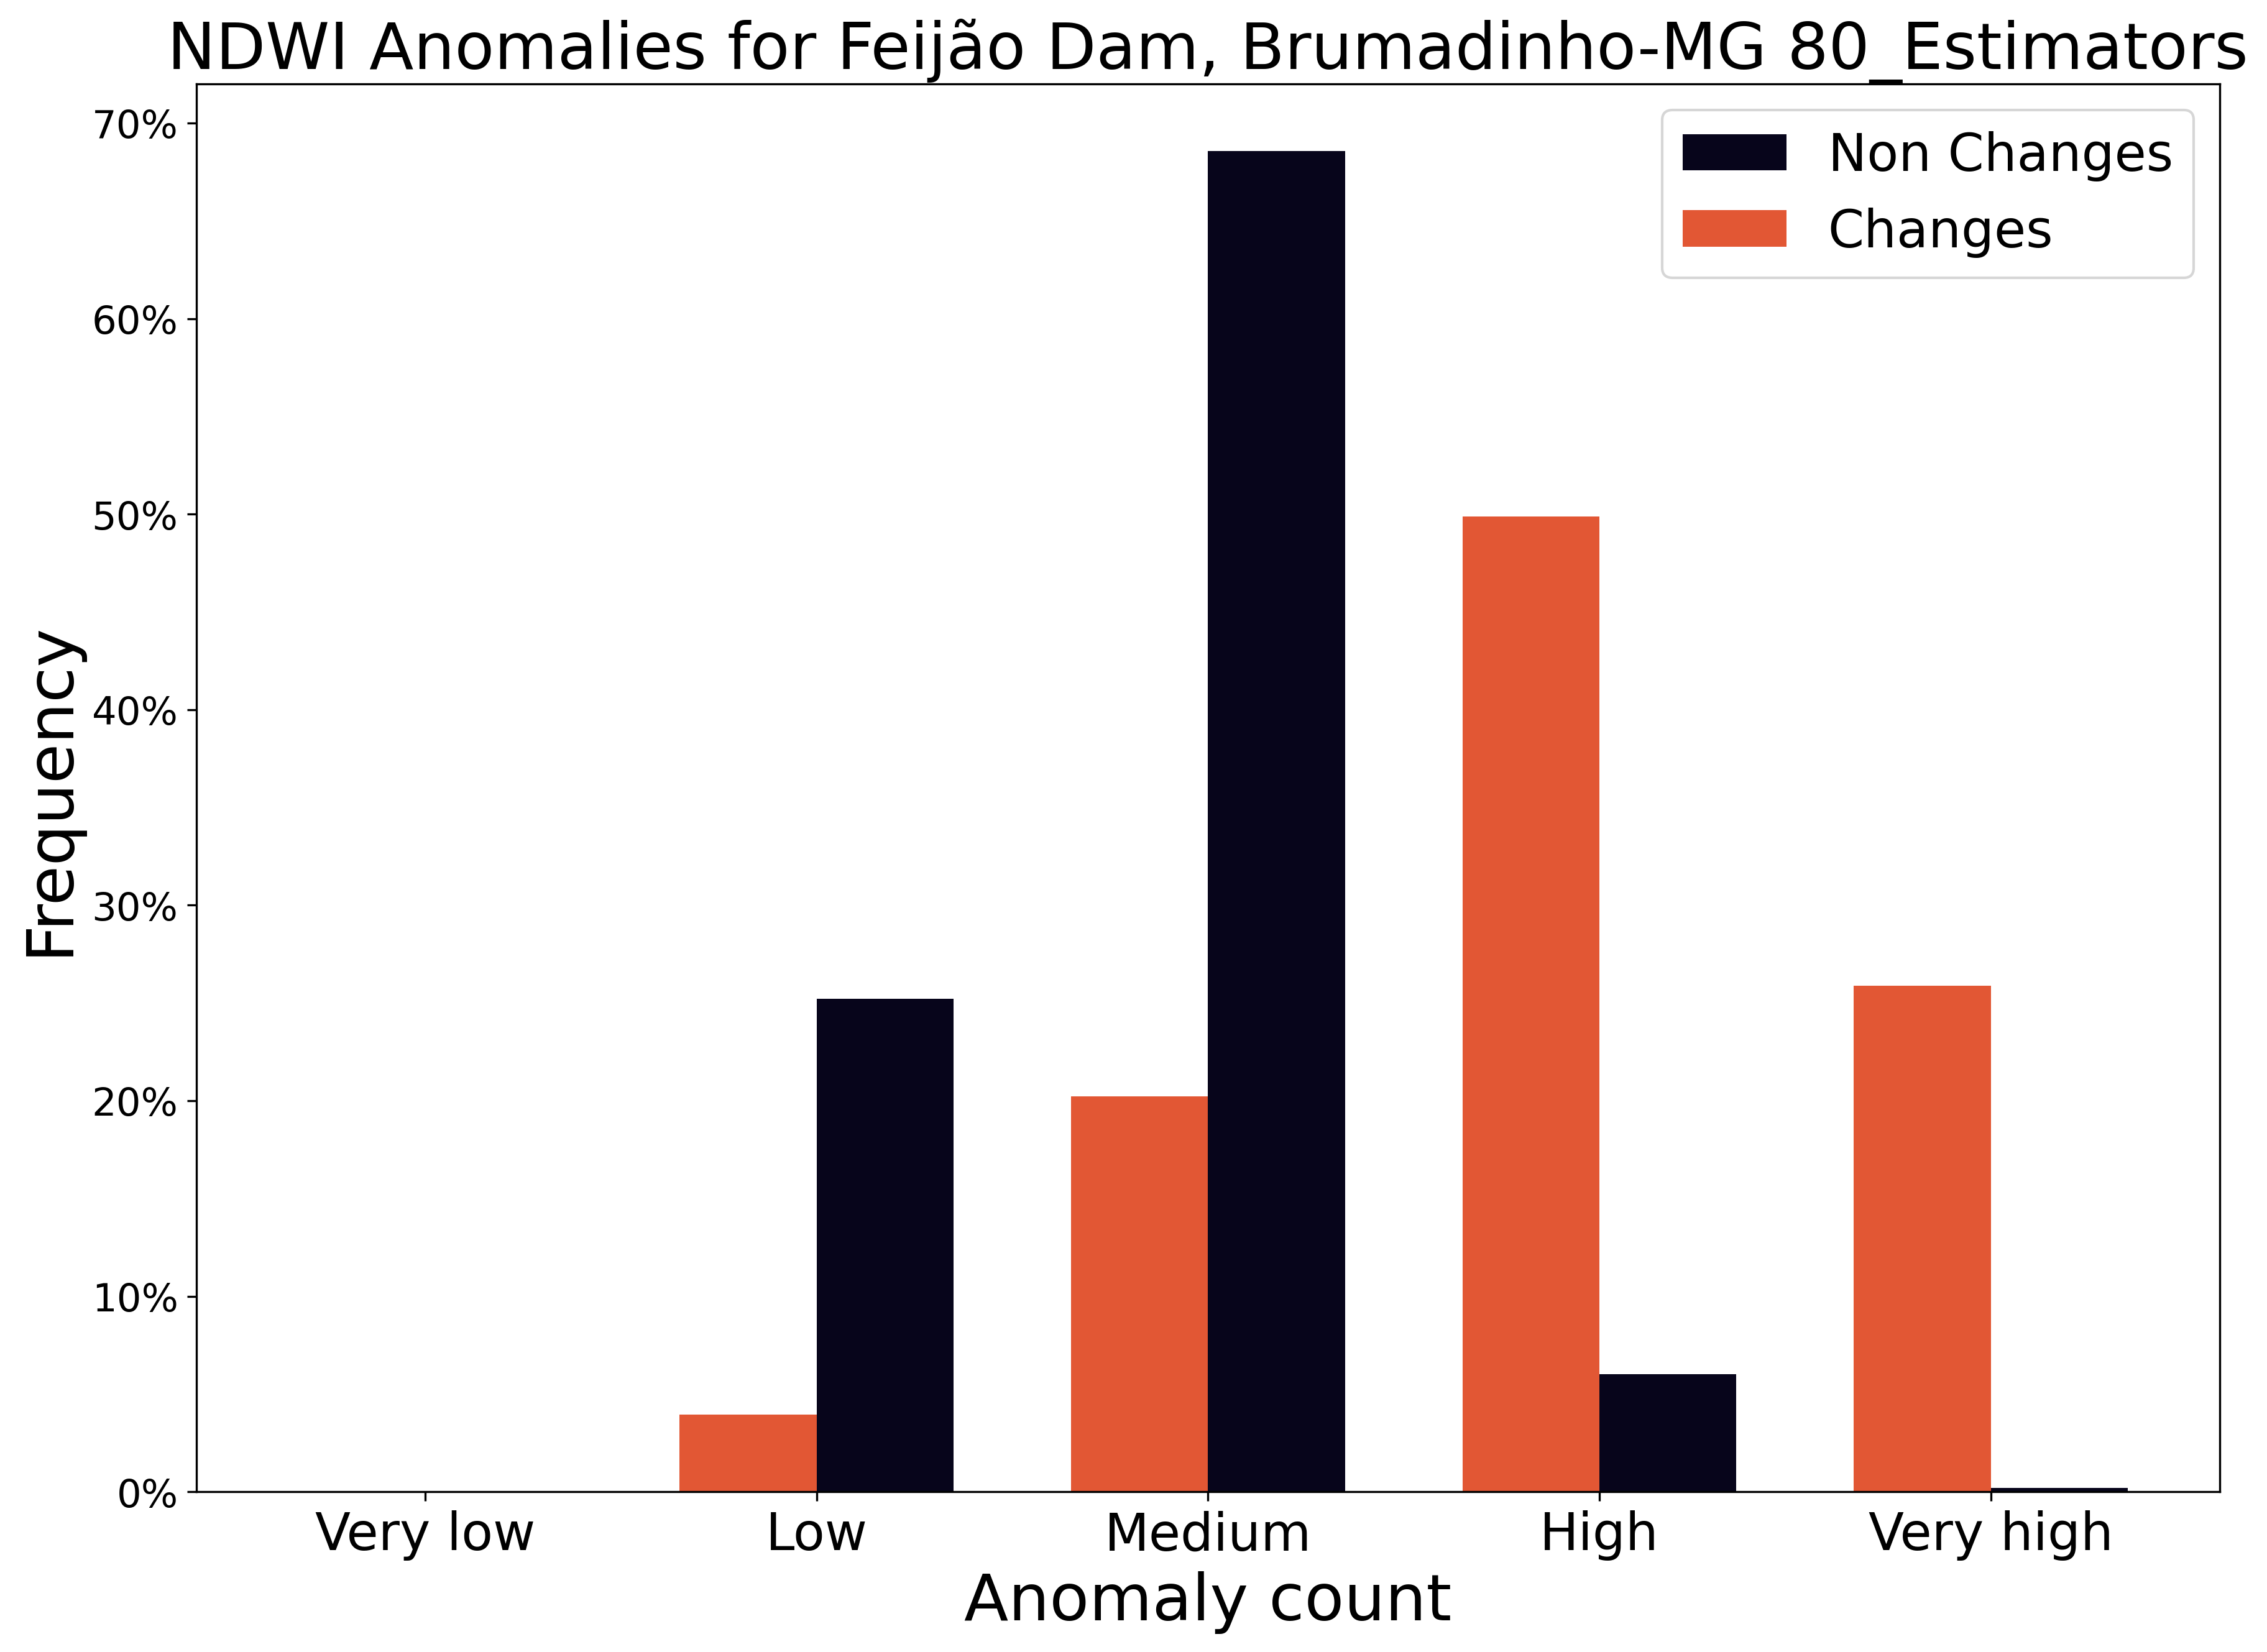

In [11]:
dicio_lab_if = {}

for t in dict_if_path:
    dfy, dfy1, dfy2 = gera_data(bru_shp_path,bru_shp_path_no, dict_if_path[t])
    dfif_0 = aplica_labels(dfy1,64)
    nome1 = 'changes_' + str(t)
    dicio_lab_if[nome1] = dfif_0
    dfif_1 = aplica_labels(dfy2,64)
    nome2 = 'unchanges_' + str(t) 
    dicio_lab_if[nome2] = dfif_1
    histo_gera(dfif_0,dfif_1,t)
    plt.show()

In [12]:
titles = list(dicio_lab_if.keys())
uy2 = pd.DataFrame()
for i in titles:
    okl = dicio_lab_if[i]['label'].value_counts()
    t = okl.sum()
    okl = okl/t
    uy = pd.DataFrame(okl)
    uy = uy.fillna(0)
    uy = uy.set_axis([i], axis=1, inplace=False)
    uy2 = pd.concat([uy,uy2], axis=1)

saida2 = uy2.fillna(0)
saida2

,unchanges_80_Estimators,changes_80_Estimators,unchanges_60_Estimators,changes_60_Estimators,unchanges_40_Estimators,changes_40_Estimators,unchanges_20_Estimators,changes_20_Estimators,unchanges_100_Estimators,changes_100_Estimators
Medium,0.685725,0.202155,0.513636,0.250766,0.338913,0.233424,0.460786,0.353158,0.753244,0.220023
Low,0.252022,0.039590,0.453075,0.067794,0.631371,0.085924,0.520218,0.087238,0.179989,0.033984
High,0.059996,0.498905,0.029340,0.487519,0.018055,0.503460,0.016739,0.423053,0.062253,0.490321
Very high,0.001881,0.258825,0.001317,0.191819,0.000564,0.172024,0.000940,0.134711,0.004326,0.255409
Very low,0.000376,0.000526,0.002633,0.002102,0.011096,0.005168,0.001317,0.001839,0.000188,0.000263


In [13]:
saida2.to_csv('../../Brumadinho/csv/hist_bars_IF_Bru.csv')

### Make confusion matrix

In [14]:
teste = list(dicionario_labels.keys())
teste

['changes_0.001_nu',
 'unchanges_0.001_nu',
 'changes_0.005_nu',
 'unchanges_0.005_nu',
 'changes_0.01_nu',
 'unchanges_0.01_nu',
 'changes_0.05_nu',
 'unchanges_0.05_nu',
 'changes_0.1_nu',
 'unchanges_0.1_nu']

In [15]:
def inicio_matcon(df1):
    df1.loc[df1['label']=="Very high", 'name'] = 'Changed'
    df1.loc[df1['label']=="High", 'name'] = 'Changed'
    df1.loc[df1['label']=="Medium", 'name'] = 'Transition'
    df1.loc[df1['label']=="Low", 'name'] = 'Unchanged'
    df1.loc[df1['label']=="Very low", 'name'] = 'Unchanged'
    return df1

In [16]:
def accuracy(df):
    soma = 0
    for i in range(len(df)):
        soma += df.iloc[i,i]
        
    res = soma/df.sum().sum()
    return res

def norm_accuracy(df):
    soma = 0
    for i in range(len(df)):
        soma += df.iloc[i,i]
        
    res = soma/2
    return res

def random_accuracy(df):
    soma = 0
    for i in range(len(df)):
        soma += df.iloc[0,i]
        
    p1 = accuracy(df)
    p2 = soma/df.sum().sum()
    res = p1*p2 + (1-p1)*(1-p2)
    return res

def norm_random_accuracy(df):
    soma = 0
    for i in range(len(df)):
        soma += df.iloc[0,i]
        
    p1 = norm_accuracy(df)
    p2 = soma/2
    res = p1*p2 + (1-p1)*(1-p2)
    return res

def kappa(df):
    res = (accuracy(df) - random_accuracy(df))/(1-random_accuracy(df))
    return res

def norm_kappa(df):
    res = (norm_accuracy(df) - norm_random_accuracy(df))/(1 - norm_random_accuracy(df))
    return res

### OCSVM

In [17]:
dict_matcon = {}
data_metrica = pd.DataFrame()
for i in range(int(len(teste)/2)):
    df1 = dicionario_labels[teste[2*i]]
    df1 = inicio_matcon(df1)
    df2 = dicionario_labels[teste[2*i+1]]
    df2 = inicio_matcon(df2)
    ni = teste[2*i][8:]
    cfm_if_chgs = df1.drop(df1[df1['name']=='Transition'].index)
    cfm_if_nchgs = df2.drop(df2[df2['name']=='Transition'].index)
    vl_l = cfm_if_nchgs['name'].value_counts()/len(df2)
    vh_h = cfm_if_chgs['name'].value_counts()/len(df1)
    cm_df_if = pd.DataFrame([vh_h,vl_l], index = ['Sample of changes', 'Sample of no changes']).fillna(0)
    dict_matcon[i] = cm_df_if
    data_metrica.loc[ni, "Accuracy"] = accuracy(cm_df_if)
    data_metrica.loc[ni, "Kappa"] = kappa(cm_df_if)

In [18]:
data_metrica

,Accuracy,Kappa
0.001_nu,0.918223,0.785278
0.005_nu,0.917976,0.782076
0.01_nu,0.918625,0.780012
0.05_nu,0.910594,0.728168
0.1_nu,0.888899,0.627650


In [73]:
data_metrica.to_csv('../../Brumadinho/csv/kappa_ocsvm_brumadinho.csv')

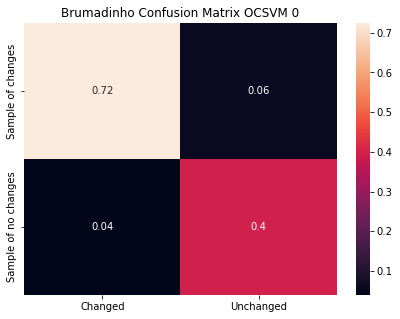

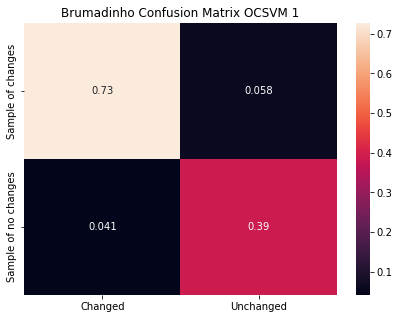

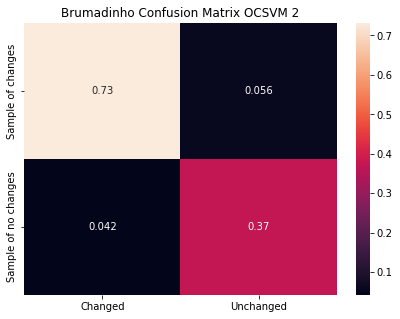

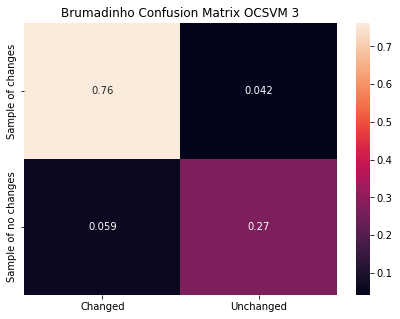

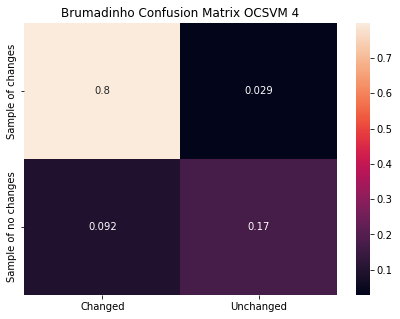

In [19]:
#Plotting the confusion matrix
import seaborn as sns
for i in dict_matcon:
    plt.figure(figsize=(7,5))
    sns.heatmap(dict_matcon[i], annot=True)
    plt.title('Brumadinho Confusion Matrix OCSVM ' + str(i))
    plt.show()

### Isolation Forest

In [20]:
teste = list(dicio_lab_if.keys())
teste

['changes_100_Estimators',
 'unchanges_100_Estimators',
 'changes_20_Estimators',
 'unchanges_20_Estimators',
 'changes_40_Estimators',
 'unchanges_40_Estimators',
 'changes_60_Estimators',
 'unchanges_60_Estimators',
 'changes_80_Estimators',
 'unchanges_80_Estimators']

In [21]:
dict_matcon_if = {}
data_metrica_if = pd.DataFrame()
teste = list(dicio_lab_if.keys())

for i in range(int(len(teste)/2)):
    df1 = dicio_lab_if[teste[2*i]]
    df1 = inicio_matcon(df1)
    df2 = dicio_lab_if[teste[2*i+1]]
    df2 = inicio_matcon(df2)
    ni = teste[2*i][8:]
    cfm_if_chgs = df1.drop(df1[df1['name']=='Transition'].index)
    cfm_if_nchgs = df2.drop(df2[df2['name']=='Transition'].index)
    vl_l = cfm_if_nchgs['name'].value_counts()/len(df2)
    vh_h = cfm_if_chgs['name'].value_counts()/len(df1)
    cm_df_if = pd.DataFrame([vh_h,vl_l], index = ['Sample of changes', 'Sample of no changes']).fillna(0)
    dict_matcon_if[i] = cm_df_if
    data_metrica_if.loc[ni, "Accuracy"] = accuracy(cm_df_if)
    data_metrica_if.loc[ni, "Kappa"] = kappa(cm_df_if)

<AxesSubplot:title={'center':'kappa score by number of estimators Brumadinho'}, xlabel='estimators', ylabel='kappa'>

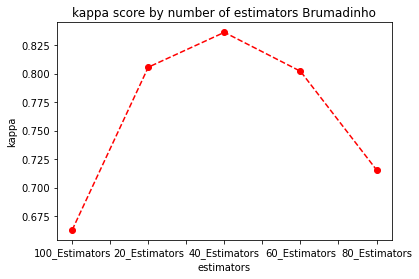

In [22]:
data_metrica_if['Kappa'].plot(title='kappa score by number of estimators Brumadinho', xlabel='estimators', ylabel='kappa',linestyle='--', marker='o',color='red')

In [23]:
data_metrica_if.to_csv('../../Brumadinho/csv/kappa_if_brumadinho.csv')

<AxesSubplot:title={'center':'kappa score by contamination Brumadinho'}, xlabel='fraction of dataset', ylabel='kappa'>

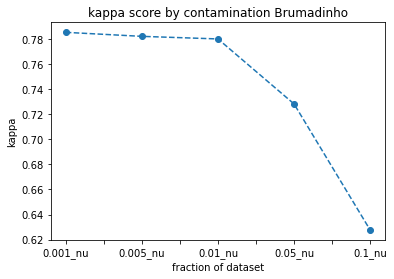

In [103]:
data_metrica['Kappa'].plot(title='kappa score by contamination Brumadinho', xlabel='fraction of dataset', ylabel='kappa',linestyle='--', marker='o')

## OC-SVM - Validation

In [172]:
with fiona.open("ic.gino/qgis/Barragens/Brumadinho/changes.shp") as shape_afetadas:
    afetadas = [feature["geometry"] for feature in shape_afetadas]

In [173]:
with rasterio.open("ic.gino/python/Brumadinho/Tiff/Bru_NDWI_OC_sentinel.tif") as regress:
    afetadas_regress, out_transform = rasterio.mask.mask(regress, afetadas, crop=True)
    out_meta = regress.meta

In [174]:
out_meta.update({"driver": "GTiff",
                 "height": afetadas_regress.shape[1],
                 "width": afetadas_regress.shape[2],
                 "transform": out_transform})

with rasterio.open("afetadas.tif", "w", **out_meta) as dest:
    dest.write(afetadas_regress)

In [175]:
afetadas_regress.flatten()

array([-99999., -99999., -99999., ...,      0.,      0., -99999.],
      dtype=float32)

In [176]:
df1 = pd.DataFrame(columns=['anomalies'],data=list(zip(afetadas_regress.flatten())))

In [177]:
remove_index = df1[df1['anomalies']<1].index

In [178]:
df1 = df1.drop(remove_index)

In [179]:
df1.head()

,anomalies
9,32.0
10,27.0
42,41.0
43,38.0
44,38.0


In [180]:
maximo = df1.max().values
maximo

array([50.])

In [181]:
df1.loc[df1["anomalies"]<int(0.2*maximo),'label'] = "Very low"
df1.loc[(df1["anomalies"]<int(0.4*maximo)) & (df1["anomalies"]>=int(0.2*maximo)),'label'] = "Low"
df1.loc[(df1["anomalies"]<int(0.6*maximo)) & (df1["anomalies"]>=int(0.4*maximo)),'label'] = "Medium"
df1.loc[(df1["anomalies"]<int(0.8*maximo)) & (df1["anomalies"]>=int(0.6*maximo)),'label'] = "High"
df1.loc[df1["anomalies"]>=int(0.8*maximo),'label'] = "Very high"

In [182]:
df1.reset_index(inplace=True, drop=True)

In [183]:
df1.loc[df1['label']=="Very high", 'id'] = 5
df1.loc[df1['label']=="High", 'id'] = 4
df1.loc[df1['label']=="Medium", 'id'] = 3
df1.loc[df1['label']=="Low", 'id'] = 2
df1.loc[df1['label']=="Very low", 'id'] = 1
df1.sort_values(by=['id'])

,anomalies,label,id
27,24.0,Medium,3.0
92,28.0,Medium,3.0
18,24.0,Medium,3.0
17,26.0,Medium,3.0
16,24.0,Medium,3.0
...,...,...,...
173,43.0,Very high,5.0
12,40.0,Very high,5.0
177,40.0,Very high,5.0
208,41.0,Very high,5.0


In [184]:
with fiona.open("ic.gino/qgis/Barragens/Brumadinho/nonchanges.shp") as shape_nafetadas:
    nafetadas = [feature["geometry"] for feature in shape_nafetadas]

In [185]:
with rasterio.open("ic.gino/python/Brumadinho/Tiff/Bru_NDWI_OC_sentinel.tif") as regress:
    nafetadas_regress, nout_transform = rasterio.mask.mask(regress, nafetadas, crop=True)
    nout_meta = regress.meta

In [186]:
nout_meta.update({"driver": "GTiff",
                 "height": nafetadas_regress.shape[1],
                 "width": nafetadas_regress.shape[2],
                 "transform": nout_transform})

with rasterio.open("nafetadas.tif", "w", **out_meta) as dest:
    dest.write(nafetadas_regress)

In [187]:
nafetadas_regress.flatten()

array([-99999., -99999., -99999., ..., -99999., -99999., -99999.],
      dtype=float32)

In [188]:
df2 = pd.DataFrame(columns=['anomalies'],data=list(zip(nafetadas_regress.flatten())))

In [189]:
remove_index = df2[df2['anomalies']<1].index
df2 = df2.drop(remove_index)
df2.loc[df2["anomalies"]<int(0.2*maximo),'label'] = "Very low"
df2.loc[(df2["anomalies"]<int(0.4*maximo)) & (df2["anomalies"]>=int(0.2*maximo)),'label'] = "Low"
df2.loc[(df2["anomalies"]<int(0.6*maximo)) & (df2["anomalies"]>=int(0.4*maximo)),'label'] = "Medium"
df2.loc[(df2["anomalies"]<int(0.8*maximo)) & (df2["anomalies"]>=int(0.6*maximo)),'label'] = "High"
df2.loc[df2["anomalies"]>=int(0.8*maximo),'label'] = "Very high"
df2.loc[df2['label']=="Very high", 'id'] = 5
df2.loc[df2['label']=="High", 'id'] = 4
df2.loc[df2['label']=="Medium", 'id'] = 3
df2.loc[df2['label']=="Low", 'id'] = 2
df2.loc[df2['label']=="Very low", 'id'] = 1
df2.sort_values(by=['id'])

,anomalies,label,id
89384,1.0,Very low,1.0
84465,1.0,Very low,1.0
50229,1.0,Very low,1.0
49970,1.0,Very low,1.0
49450,1.0,Very low,1.0
...,...,...,...
40691,32.0,High,4.0
44324,30.0,High,4.0
44325,30.0,High,4.0
44068,30.0,High,4.0


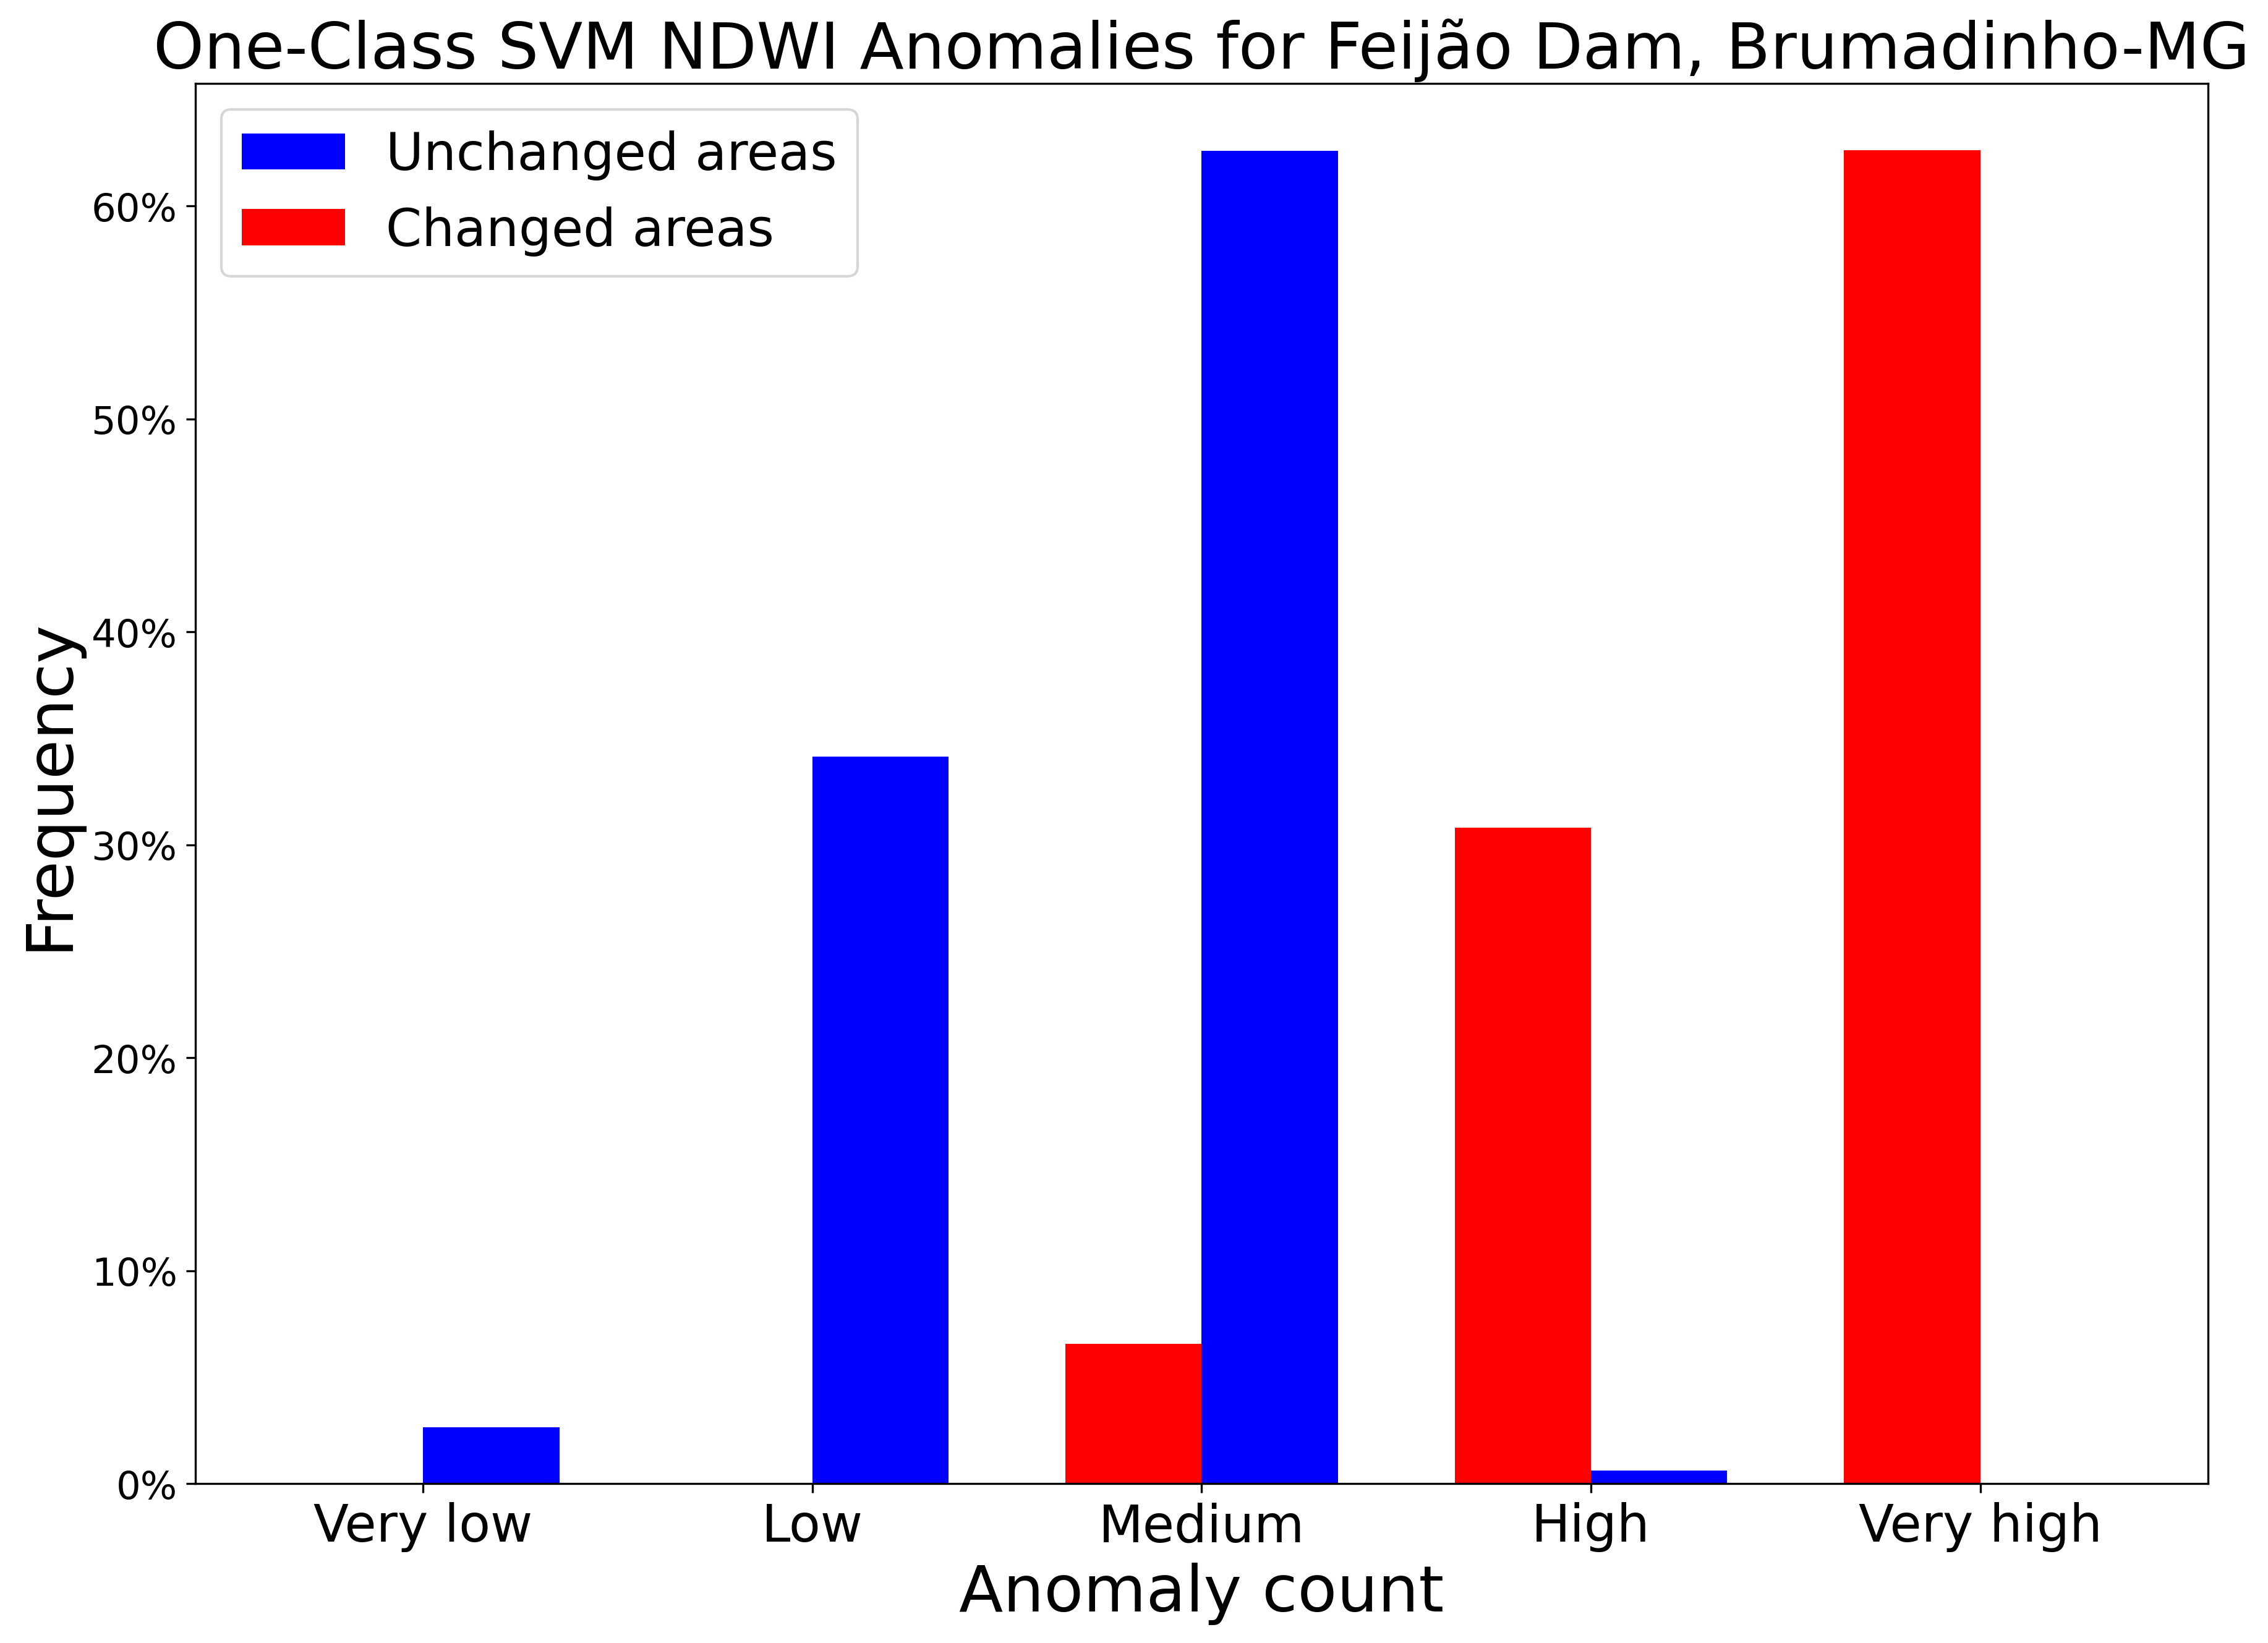

In [190]:
from matplotlib.pyplot import figure
figure(figsize=(14,10), dpi=300)

plt.title('One-Class SVM NDWI Anomalies for Feijão Dam, Brumadinho-MG', fontsize=25)
plt.xlabel('Anomaly count', fontsize=25)
plt.ylabel('Frequency', fontsize=25)

labels1 = df1.sort_values(by=['id'])['label'].unique()
t1 = []
t2 = []
for label in labels1:
    t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])
    
correct_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']
aux = [0,0,0,0,0]
cont = 0
for i in range(len(correct_labels)):
    if (correct_labels[i] in labels1)==True:
        aux[i] = t1[cont]
        cont = cont + 1
    
labels2 = df2.sort_values(by=['id'])['label'].unique()
for label in labels2:
    t2.append(df2.sort_values(by=['id'])['label'].value_counts()[label])
    
aux2 = [0,0,0,0,0]
cont = 0
for i in range(len(correct_labels)):
    if (correct_labels[i] in labels2)==True:
        aux2[i] = t2[cont]
        cont = cont + 1

yy = aux/np.sum(aux)
y2 = aux2/np.sum(aux2)
xx = np.arange(len(correct_labels))
x2 = np.arange(len(correct_labels))
width = 0.35

ax = plt.subplot(111)
ax.bar(x2 + width/2, y2, width, color='b', label='Unchanged areas')
ax.bar(xx - width/2, yy, width, color='r', label='Changed areas')


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xticks(xx)
ax.set_xticklabels(correct_labels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
ax.legend()
plt.legend(fontsize=20)
plt.savefig('ic.gino/python/Brumadinho/graphs/OCSVM_NDWI_Bru.svg')

In [191]:
df1.loc[df1['label']=="Very high", 'name'] = 'Changed'
df1.loc[df1['label']=="High", 'name'] = 'Changed'
df1.loc[df1['label']=="Medium", 'name'] = 'Transition'
df1.loc[df1['label']=="Low", 'name'] = 'Unchanged'
df1.loc[df1['label']=="Very low", 'name'] = 'Unchanged'

try:
    df2.loc[df2['label']=="Very high", 'name'] = 'Changed'
    df2.loc[df2['label']=="High", 'name'] = 'Changed'
    df2.loc[df2['label']=="Medium", 'name'] = 'Transition'
    df2.loc[df2['label']=="Low", 'name'] = 'Unchanged'
    df2.loc[df2['label']=="Very low", 'name'] = 'Unchanged'
except:
    print('não deu')

cfm_ocsvm_chgs = df1.drop(df1[df1['name']=='Transition'].index)
cfm_ocsvm_nchgs = df2.drop(df2[df2['name']=='Transition'].index)

vl_l_o = cfm_ocsvm_nchgs['name'].value_counts()/len(df2)
vh_h_o = cfm_ocsvm_chgs['name'].value_counts()/len(df1)

In [192]:
display(vl_l,vh_h)

Unchanged    1.0
Name: name, dtype: float64

Changed      0.698361
Unchanged    0.026230
Name: name, dtype: float64

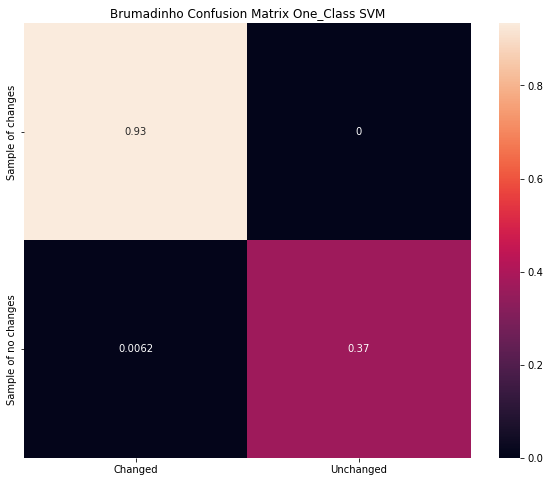

In [193]:
cm_df_oc = pd.DataFrame([vh_h_o,vl_l_o], index = ['Sample of changes', 'Sample of no changes']).fillna(0)

#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_oc, annot=True)
plt.title('Brumadinho Confusion Matrix One_Class SVM')
plt.show()

In [194]:
print("Accuracy", accuracy(cm_df_oc), norm_accuracy(cm_df_oc))
print("Kappa", kappa(cm_df_oc), norm_kappa(cm_df_oc))

Accuracy 0.9952456572781386 0.651116691736991
Kappa 0.9834856207606736 0.3157933886634582


# IMAGEM SEM DETER

In [28]:
from scipy.stats import wilcoxon
from scipy.stats import mstats
from scipy.stats import ks_2samp

In [29]:
ks_2samp(df_aval['Regioes não afetadas'], df_aval['Regioes afetadas'])

KstestResult(statistic=0.3, pvalue=0.7869297884777761)

In [30]:
wilcoxon(df_aval['Regioes não afetadas'], df_aval['Regioes afetadas'])

WilcoxonResult(statistic=26.0, pvalue=0.921875)

In [31]:
mstats.pearsonr(df_aval['Regioes não afetadas'], df_aval['Regioes afetadas'])

(0.9469087803316883, 3.2593258046757225e-05)

In [32]:
mstats.spearmanr(df_aval['Regioes não afetadas'], df_aval['Regioes afetadas'])

SpearmanrResult(correlation=0.5151515151515151, pvalue=0.12755286970323426)

In [33]:
import random

In [34]:
tst = random.sample(range(0, 747470), 747470)

In [35]:
index_tst = np.zeros(84545)

In [36]:
for i in range (0, 84545):
    index_tst[i] = tst[i]

In [37]:
df6 = df5.loc[df5.index.isin(index_tst)]

In [38]:
df6

,%proba
4,0.997541
7,0.999945
13,0.971189
14,0.997363
18,0.999974
...,...
747423,0.370719
747428,0.521241
747437,0.298354
747459,0.990487


In [39]:
df6.reset_index(drop=True)

,%proba
0,0.997541
1,0.999945
2,0.971189
3,0.997363
4,0.999974
...,...
84540,0.370719
84541,0.521241
84542,0.298354
84543,0.990487


In [40]:
df6.rename(columns={'%proba':'allimage'}, inplace=True)

/home/nascimento/anaconda3/envs/felipe/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
df6.reset_index(drop=True, inplace=True)

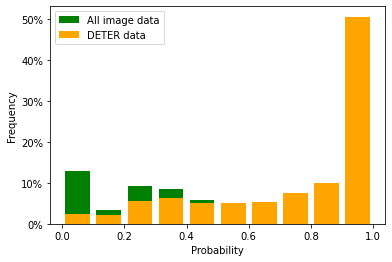

In [42]:
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.hist(df6, bins=10, rwidth=0.8, color='g', label='All image data',weights=np.ones(len(df6))/len(df6))
plt.hist(df1, bins=10, rwidth=0.8, color='orange', label='DETER data',weights=np.ones(len(df1))/len(df1))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()

In [43]:
binst = np.linspace(0,1,10)

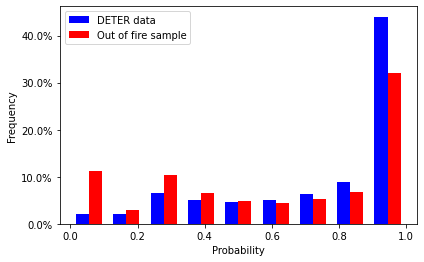

In [114]:
plt.figure(figsize=(6.4,4))

plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.hist([df1['%proba'], df6['allimage']], binst, rwidth=0.7, color=['blue','red'], label=['DETER data','Out of fire sample'])

plt.gca().yaxis.set_major_formatter(PercentFormatter(100000))

plt.legend()

plt.savefig('histo_regress.pdf')

In [45]:
df6

,allimage
0,0.997541
1,0.999945
2,0.971189
3,0.997363
4,0.999974
...,...
84540,0.370719
84541,0.521241
84542,0.298354
84543,0.990487


In [46]:
deterdf = df1
allimgdf = df6

In [47]:
deterdf['id']=0
allimgdf['id']=0

<ipython-input-47-756054f058d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allimgdf['id']=0


In [48]:
for i in range (0, 84545):
    if deterdf.at[i,'%proba']>0.5:
        deterdf.at[i, 'id'] = 1
    

In [49]:
for i in range (0, 84545):
    if allimgdf.at[i,'allimage']>0.5:
        allimgdf.at[i, 'id'] = 1

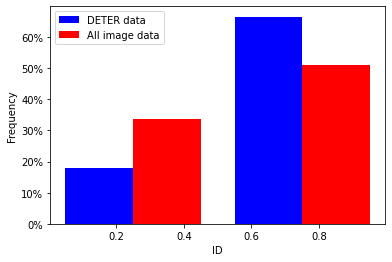

In [50]:
plt.xlabel('ID')
plt.ylabel('Frequency')

plt.hist([deterdf['id'], allimgdf['id']], bins=2, rwidth=0.8, color=['blue','red'], label=['DETER data','All image data'])

plt.gca().yaxis.set_major_formatter(PercentFormatter(100000))

plt.legend()

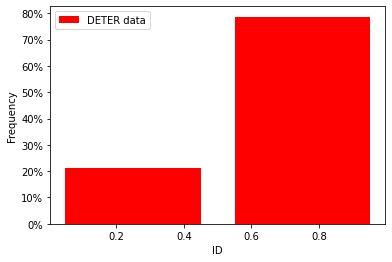

In [51]:
plt.xlabel('ID')
plt.ylabel('Frequency')

(ndmcnemar, bdmcnemar, patchesdmcnemar) = plt.hist(deterdf['id'], bins=2, rwidth=0.8, color='red', label='DETER data',weights=np.ones(len(deterdf))/len(deterdf))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()

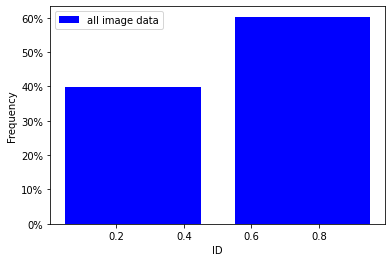

In [52]:
plt.xlabel('ID')
plt.ylabel('Frequency')

(nimgmcnemar, bimgmcnemar, patchesimgmcnemar) = plt.hist(allimgdf['id'], bins=2, rwidth=0.8, color='blue', label='all image data',weights=np.ones(len(allimgdf))/len(allimgdf))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()

In [53]:
ndmcnemar

array([0.21278609, 0.78721391])

In [54]:
nimgmcnemar

array([0.39693654, 0.60306346])

In [55]:
data = [[0.1801171, 0.21278609],
        [0.60709681, 0]
       ]

In [56]:
from statsmodels.stats.contingency_tables import mcnemar

In [57]:
print(mcnemar(data))

pvalue      1.0
statistic   0.21278609


/home/nascimento/anaconda3/envs/felipe/lib/python3.8/site-packages/statsmodels/stats/contingency_tables.py:1339: FutureWarning: exact can only be used with tables containing integers. This warning will become a ValueError after 0.12.
  warnings.warn("exact can only be used with tables containing "


In [58]:
import pymannkendall

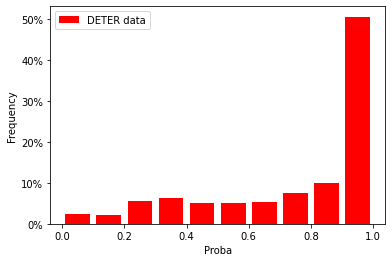

In [66]:
plt.xlabel('Proba')
plt.ylabel('Frequency')

(n_deter, bin_deter, patches_deter) = plt.hist(df1['%proba'], bins=10, rwidth=0.8, color='red', label='DETER data', weights=np.ones(len(df1))/len(df1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()

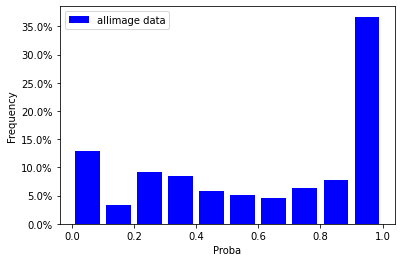

In [70]:
plt.xlabel('Proba')
plt.ylabel('Frequency')

(n_img, bin_img, patches_img) = plt.hist(df6['allimage'], bins=10, rwidth=0.8, color='blue', label='allimage data', weights=np.ones(len(df6))/len(df6))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()

In [78]:
testemk = n_deter-n_img

In [79]:
pymannkendall.original_test(testemk)

Mann_Kendall_Test(trend='increasing', h=True, p=0.00034661935113455833, z=3.5777087639996634, Tau=0.9111111111111111, s=41.0, var_s=125.0, slope=0.011227748536283317, intercept=-0.053919510319951694)

In [80]:
testemk

array([-0.1060382 , -0.01176888, -0.0362174 , -0.022627  , -0.00749897,
        0.00070968,  0.0086936 ,  0.01292803,  0.02257969,  0.13923946])

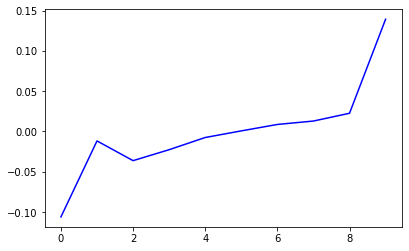

In [113]:
plt.figure(figsize=(6.4,4))
plt.plot(testemk, color='blue')

plt.savefig('difference_datas.pdf')